# **Conagra Project**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.stats.outliers_influence import variance_inflation_factor
from fixedeffect.iv import iv2sls, ivgmm, ivtest
from fixedeffect.fe import fixedeffect, did, getfe
from fixedeffect.utils.panel_dgp import gen_data
#from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
pd.set_option('display.max_columns', None)

In [2]:
# Check the Working Directory
os.getcwd()

'/Users/min/Desktop/2023 Spring Semester/BUAN 6337 Predictive Analytics for Data Science/Project/Data'

# Import Datasets

In [3]:
df_tablespreads = pd.read_csv('df_tablespreads.csv')

In [4]:
df_tablespreads_US = pd.read_csv('df_tablespreads_US.csv')

In [5]:
df_tablespreads_Reg = pd.read_csv('df_tablespreads_Reg.csv')

In [6]:
df_tablespreads_US_butter = pd.read_csv('df_tablespreads_US_butter.csv')

In [7]:
df_tablespreads_US_margarine = pd.read_csv('df_tablespreads_US_margarine.csv')

In [8]:
df_oil = pd.read_csv('df_oil.csv')
df_oil_US = pd.read_csv('df_oil_US.csv')

In [9]:
df_oil_Reg = pd.read_csv('df_oil_Reg.csv')

In [10]:
df_spray = pd.read_csv('df_spray.csv')
df_spray_US = pd.read_csv('df_spray_US.csv')

In [11]:
df_spray_Reg = pd.read_csv('df_spray_Reg.csv')

# Data Exploration

In [12]:
pd.options.display.float_format = '{:.2f}'.format

In [13]:
df_tablespreads_US_tot_sal_by_year = df_tablespreads_US.groupby('Year')['Total Sales'].agg(['sum'])
df_tablespreads_US_tot_sal_by_year

,sum
Year,
2018,3931065983.46
2019,4008196031.80
2020,4753616960.49
2021,4216322537.43
2022,5023678726.19
2023,101355599.19


In [14]:
df_tablespreads_US_butter_tot_sal_by_year = df_tablespreads_US_butter.groupby('Year')['Total Sales'].agg(['sum'])
df_tablespreads_US_butter_tot_sal_by_year

,sum
Year,
2018,2659396963.63
2019,2743333676.20
2020,3344972640.76
2021,2923039185.42
2022,3418443932.66
2023,69576406.56


In [15]:
df_tablespreads_US_mar_tot_sal_by_year = df_tablespreads_US_margarine.groupby('Year')['Total Sales'].agg(['sum'])
df_tablespreads_US_mar_tot_sal_by_year

,sum
Year,
2018,1271669019.83
2019,1264862355.60
2020,1408644319.73
2021,1293283352.02
2022,1605234793.53
2023,31779192.62


In [16]:
df_oil_US_tot_sal_by_year = df_oil_US.groupby('Year')['Total Sales'].agg(['sum'])
df_oil_US_tot_sal_by_year

,sum
Year,
2018,1770219297.63
2019,1753578020.91
2020,2087974069.45
2021,2170141167.80
2022,2698622736.62
2023,51697847.21


In [17]:
df_spray_US_tot_sal_by_year = df_spray_US.groupby('Year')['Total Sales'].agg(['sum'])
df_spray_US_tot_sal_by_year

,sum
Year,
2018,368265032.53
2019,371383462.17
2020,480902647.96
2021,468134572.26
2022,498248685.65
2023,9196381.58


# Answering Question 3. Are there price gaps and/or price thresholds that cause an unexpected impact on sales and/or velocities?

## **Fixed Effect Model**

### **Using US Tablespreads Data**

In [18]:
# Create a new column called "Price Gap' by differencing the Price per Unite No Merch and Any Merch
df_tablespreads_US['Price Gap'] = df_tablespreads_US['Price per Unit No Merch'] - df_tablespreads_US['Price per Unit Any Merch']

In [19]:
# Creating dummies variables to indicate holidays and the beginning month of Covid-19
df_tablespreads_US['Covid-19 Break-Out'] = df_tablespreads_US['Date'].apply(lambda x: 1 if x >= '2020-03-01' and x <= '2020-06-30' else 0)
df_tablespreads_US['Holiday Season'] = df_tablespreads_US['Month'].apply(lambda x: 1 if x in [11, 12] else 0)

In [20]:
df_oil_US_new = df_oil_US.groupby(by = ['Date', 'Manufacturer']).sum().reset_index()
df_oil_US_new = df_oil_US_new.drop('Unnamed: 0', axis = 1)
df_oil_US_new['Price Gap'] = df_oil_US_new['Price per Unit No Merch'] - df_oil_US_new['Price per Unit Any Merch']
df_oil_US_new

,Date,Manufacturer,Dollar Sales No Merch,Dollar Sales Any Merch,Unit Sales No Merch,Unit Sales Any Merch,Volume Sales No Merch,Volume Sales Any Merch,Price per Unit,Price per Unit No Merch,Price per Unit Any Merch,Price per Volume,Price per Volume No Merch,Price per Volume Any Merch,ACV Weighted Distribution No Merch,ACV Weighted Distribution Any Merch,Base Unit Sales,Base Volume Sales,Base Dollar Sales,Incremental Units,Incremental Volume,Incremental Dollars,Promotion,Total Sales,Year,Month,Day,Price Gap
0,2018-01-14,4TH & HEART,662.26,137.84,52.22,13.69,52.22,13.69,12.14,12.68,10.07,12.14,12.68,10.07,0.19,0.04,58.94,58.94,745.84,6.97,6.97,54.26,1,800.10,2018,1,14,2.62
1,2018-01-14,A&M GOURMET FOODS INC,34075.47,68.47,8582.92,25.00,18131.43,52.81,3.97,3.97,2.74,1.88,1.88,1.30,14.45,0.05,8600.53,18168.63,34137.14,7.39,15.61,6.80,1,34143.94,2018,1,14,1.23
2,2018-01-14,AC FOODS WHLSL,729.90,1042.22,91.35,208.86,385.96,887.10,5.90,7.99,4.99,1.39,1.89,1.17,0.01,0.01,219.94,931.91,1371.61,80.28,341.15,400.52,1,1772.13,2018,1,14,3.00
3,2018-01-14,ACEITARA GENERAL DEHEZA S A,27.51,923.24,5.01,179.48,15.97,572.11,5.15,5.49,5.14,1.62,1.72,1.61,0.01,0.06,126.23,402.36,740.03,58.26,185.72,210.72,1,950.75,2018,1,14,0.35
4,2018-01-14,ACH FOOD CO,3340035.24,919484.44,524949.90,196778.28,2736745.48,831551.61,7.99,8.64,6.37,2.17,2.30,1.90,81.44,16.87,604052.84,3068723.36,3787170.66,117675.34,499573.73,472349.02,2,4259519.68,4036,2,28,2.27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79353,2023-01-01,YELL O GLOW CORP,9244.81,0.00,231.18,0.00,4045.61,0.00,39.99,39.99,0.00,2.29,2.29,0.00,0.25,0.00,231.18,4045.61,9244.81,0.00,0.00,0.00,0,9244.81,2023,1,1,39.99
79354,2023-01-01,YODER POPCORN CO INC,106.19,0.00,16.29,0.00,16.29,0.00,6.52,6.52,0.00,6.52,6.52,0.00,0.01,0.00,16.29,16.29,106.19,0.00,0.00,0.00,0,106.19,2023,1,1,6.52
79355,2023-01-01,YUG RUSI,1040.23,0.00,130.19,0.00,275.03,0.00,7.99,7.99,0.00,3.78,3.78,0.00,0.07,0.00,130.19,275.03,1040.23,0.00,0.00,0.00,0,1040.23,2023,1,1,7.99
79356,2023-01-01,ZT KRUSZWICA S A,103.67,1209.04,15.47,220.23,32.68,465.23,5.57,6.70,5.49,2.64,3.17,2.60,0.01,0.02,53.71,113.46,333.22,181.99,384.45,979.49,1,1312.71,2023,1,1,1.21


In [21]:
df_oil_US_new1 = df_oil_US_new[['Date', 'Manufacturer', 'Total Sales', 'Price Gap', 'Promotion']]

In [22]:
df_US = pd.merge(df_tablespreads_US, df_oil_US_new1, how = 'left', left_on = ['Date', 'CAG Manufacturer Value'], right_on = ['Date', 'Manufacturer'])

In [23]:
df_US = df_US.rename(columns = {'Total Sales_x': 'Total Sales_Tablespreads', 'Price Gap_x' : 'Price Gap_Tablespreads', 
                                'Total Sales_y': 'Total Sales_Oil', 'Price Gap_y': 'Price Gap_Oil', 'Promotion_x': 'Promotion'}, errors="raise")
df_US

,Unnamed: 0,Geography,Time,Product,UPC 13 digit,Dollar Sales No Merch,Dollar Sales Any Merch,Unit Sales No Merch,Unit Sales Any Merch,Volume Sales No Merch,Volume Sales Any Merch,Price per Unit,Price per Unit No Merch,Price per Unit Any Merch,Price per Volume,Price per Volume No Merch,Price per Volume Any Merch,ACV Weighted Distribution No Merch,ACV Weighted Distribution Any Merch,Base Unit Sales,Base Volume Sales,Base Dollar Sales,Incremental Units,Incremental Volume,Incremental Dollars,CAG Major Brand Value,CAG Manufacturer Value,Sub-Category Name,CAG Category Value,CAG Count Value,CAG Ounces Value,CAG Form Value,Form,CAG Tier Value,Promotion,Total Sales_Tablespreads,Date,Year,Month,Day,Price Gap_Tablespreads,Covid-19 Break-Out,Holiday Season,Manufacturer,Total Sales_Oil,Price Gap_Oil,Promotion_y
0,0,Total US - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD BOX SPREA...,29000008222,1255982.31,168416.46,1241793.85,182993.87,1241793.85,182993.87,1.00,1.01,0.92,1.00,1.01,0.92,64.38,5.72,1344519.22,1344519.22,1363962.33,80268.50,80268.50,60436.44,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,1 CT,16 OZ,ALL OTHER FORM,SPREAD,VALUE,1,1424398.77,2018-01-14,2018,1,14,0.09,0,0,CONAGRA BRANDS,176076.18,0.56,1.00
1,1,Total US - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD BOX SPREA...,29000008563,150700.94,15573.72,152528.30,17263.34,152528.30,17263.34,0.98,0.99,0.90,0.98,0.99,0.90,27.39,1.85,162612.15,162612.15,160867.53,7179.48,7179.48,5407.13,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,1 CT,16 OZ,STICKS,SPREAD,VALUE,1,166274.66,2018-01-14,2018,1,14,0.09,0,0,CONAGRA BRANDS,176076.18,0.56,1.00
2,2,Total US - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD BOX STICK...,70272006101,17400.30,644.40,17360.27,717.50,17360.27,717.50,1.00,1.00,0.90,1.00,1.00,0.90,6.92,0.13,17760.79,17760.79,17786.94,316.98,316.98,257.76,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,4 CT,16 OZ,STICKS,STICK,VALUE,1,18044.70,2018-01-14,2018,1,14,0.10,0,0,CONAGRA BRANDS,176076.18,0.56,1.00
3,3,Total US - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD INDIVDL W...,29000008252,287646.61,14088.69,152709.01,8311.54,305418.02,16623.08,1.87,1.88,1.70,0.94,0.94,0.85,18.72,1.43,159778.27,319556.53,300250.53,1242.29,2484.57,1484.78,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,8 CT,32 OZ,STICKS,STICK,VALUE,1,301735.30,2018-01-14,2018,1,14,0.19,0,0,CONAGRA BRANDS,176076.18,0.56,1.00
4,4,Total US - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD PLASTIC T...,27000009002,360198.99,52619.03,228163.16,37591.80,213902.96,35242.32,1.55,1.58,1.40,1.66,1.68,1.49,45.92,4.99,248489.81,232959.20,395016.99,17265.16,16186.08,17801.03,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,1 CT,15 OZ,TUBS,SPREAD,VALUE,1,412818.02,2018-01-14,2018,1,14,0.18,0,0,CONAGRA BRANDS,176076.18,0.56,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314085,1126424,Total US - Multi Outlet + Conv,Week Ending 01-01-23,WILDBRINE RFG BUTTER SUBSTITUTE PLASTIC TUB SP...,857859007121,715.45,0.00,106.79,0.00,80.09,0.00,6.70,6.70,6.70,8.93,8.93,8.93,0.15,0.00,106.79,80.09,715.45,0.00,0.00,0.00,WILDBRINE,WILDBRINE LLC,Margarine/Spreads,TABLESPREADS,1 CT,12 OZ,TUBS,SPREAD,SUPER PREMIUM,0,715.45,2023-01-01,2023,1,1,0.00,0,0,NaN,NaN,NaN,NaN
314086,1126425,Total US - Multi Outlet + Conv,Week Ending 01-01-23,TABLE MAID RFG VEGETABLE OIL SPREAD PLASTIC TU...,26700159071,955.55,258.95,228.05,64.90,427.60,121.69,4.15,4.19,3.99,2.21,2.23,2.13,0.06,0.02,292.96,549.29,1214.50,0.00,0.00,0.00,TABLE MAID,WILSEY FOODS INC,Margarine/Spreads,TABLESPREADS,1 CT,30 OZ,TUBS,SPREAD,VALUE,1,1214.50,2023-01-01,2023,1,1,0.20,0,0,NaN,NaN,NaN,NaN
314087,1126426,Total US - Multi Outlet +

In [24]:
df_spray_US_new = df_spray_US.groupby(by = ['Date', 'Manufacturer']).sum().reset_index()
df_spray_US_new = df_spray_US_new.drop('Unnamed: 0', axis = 1)
df_spray_US_new['Price Gap'] = df_spray_US_new['Price per Unit No Merch'] - df_spray_US_new['Price per Unit Any Merch']
df_spray_US_new

,Date,Manufacturer,Dollar Sales No Merch,Dollar Sales Any Merch,Unit Sales No Merch,Unit Sales Any Merch,Volume Sales No Merch,Volume Sales Any Merch,Price per Unit,Price per Unit No Merch,Price per Unit Any Merch,Price per Volume,Price per Volume No Merch,Price per Volume Any Merch,ACV Weighted Distribution No Merch,ACV Weighted Distribution Any Merch,Base Unit Sales,Base Volume Sales,Base Dollar Sales,Incremental Units,Incremental Volume,Incremental Dollars,Promotion,Total Sales,Year,Month,Day,Price Gap
0,2018-01-14,4TH & HEART,836.77,255.27,103.62,46.35,32.38,14.48,7.28,8.08,5.51,23.30,25.84,17.62,0.27,0.12,142.16,44.42,1075.97,7.81,2.44,16.06,1,1092.04,2018,1,14,2.57
1,2018-01-14,ACH FOOD COMPANIES,38022.42,744.39,17155.77,325.99,5361.18,101.87,2.22,2.22,2.28,7.10,7.09,7.31,19.66,0.18,17335.26,5417.27,38468.98,146.49,45.78,297.84,1,38766.81,2018,1,14,-0.07
2,2018-01-14,B & G FOODS INC.,429165.05,25694.38,176175.45,11472.44,63861.72,4235.54,11.08,11.13,10.26,30.52,30.69,28.09,83.49,6.84,182686.64,66156.94,445777.58,4961.25,1940.32,9081.85,4,454859.44,8072,4,56,0.87
3,2018-01-14,BEDESSEE IMPORTS INC,29.31,0.00,13.70,0.00,4.28,0.00,2.14,2.14,0.00,6.85,6.85,0.00,0.01,0.00,13.70,4.28,29.31,0.00,0.00,0.00,0,29.31,2018,1,14,2.14
4,2018-01-14,BENEFICIAL BLENDS LLC,5054.68,11.96,687.54,2.29,214.86,0.71,7.34,7.35,5.23,23.50,23.53,16.74,2.37,0.01,689.83,215.57,5066.64,0.00,0.00,0.00,1,5066.64,2018,1,14,2.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10693,2023-01-01,VALCO ENTERPRISES,21467.42,624.43,2620.77,87.53,2211.41,73.86,8.16,8.19,7.13,9.67,9.71,8.45,1.98,0.09,2661.00,2245.35,21817.54,47.30,39.91,274.31,1,22091.85,2023,1,1,1.06
10694,2023-01-01,VEGALENE,865.25,2.40,273.75,1.20,102.66,0.45,3.16,3.16,2.00,8.42,8.43,5.33,0.95,0.01,274.95,103.11,867.65,0.00,0.00,0.00,1,867.65,2023,1,1,1.16
10695,2023-01-01,VENTURA FOODS LLC,28192.59,116.01,6881.45,30.58,2580.55,11.47,4.10,4.10,3.79,10.92,10.93,10.12,14.86,0.06,6902.17,2588.31,28273.58,9.86,3.70,35.02,1,28308.60,2023,1,1,0.30
10696,2023-01-01,WILTON INDUSTRIES INC,595.54,2.06,147.00,1.00,72.62,0.50,4.04,4.05,2.06,8.17,8.20,4.12,0.72,0.01,148.00,73.12,597.60,0.00,0.00,0.00,1,597.60,2023,1,1,1.99


In [25]:
df_spray_US_new1 = df_spray_US_new[['Date', 'Manufacturer', 'Total Sales', 'Price Gap']]

In [26]:
df_US = pd.merge(df_US, df_spray_US_new1, how = 'left', left_on = ['Date', 'CAG Manufacturer Value'], right_on = ['Date', 'Manufacturer'])

In [27]:
df_US = df_US.rename(columns = {'Total Sales': 'Total Sales_Spray', 'Price Gap' : 'Price Gap_Spray'}, errors="raise")
df_US

,Unnamed: 0,Geography,Time,Product,UPC 13 digit,Dollar Sales No Merch,Dollar Sales Any Merch,Unit Sales No Merch,Unit Sales Any Merch,Volume Sales No Merch,Volume Sales Any Merch,Price per Unit,Price per Unit No Merch,Price per Unit Any Merch,Price per Volume,Price per Volume No Merch,Price per Volume Any Merch,ACV Weighted Distribution No Merch,ACV Weighted Distribution Any Merch,Base Unit Sales,Base Volume Sales,Base Dollar Sales,Incremental Units,Incremental Volume,Incremental Dollars,CAG Major Brand Value,CAG Manufacturer Value,Sub-Category Name,CAG Category Value,CAG Count Value,CAG Ounces Value,CAG Form Value,Form,CAG Tier Value,Promotion,Total Sales_Tablespreads,Date,Year,Month,Day,Price Gap_Tablespreads,Covid-19 Break-Out,Holiday Season,Manufacturer_x,Total Sales_Oil,Price Gap_Oil,Promotion_y,Manufacturer_y,Total Sales_Spray,Price Gap_Spray
0,0,Total US - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD BOX SPREA...,29000008222,1255982.31,168416.46,1241793.85,182993.87,1241793.85,182993.87,1.00,1.01,0.92,1.00,1.01,0.92,64.38,5.72,1344519.22,1344519.22,1363962.33,80268.50,80268.50,60436.44,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,1 CT,16 OZ,ALL OTHER FORM,SPREAD,VALUE,1,1424398.77,2018-01-14,2018,1,14,0.09,0,0,CONAGRA BRANDS,176076.18,0.56,1.00,CONAGRA BRANDS,4036136.12,0.84
1,1,Total US - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD BOX SPREA...,29000008563,150700.94,15573.72,152528.30,17263.34,152528.30,17263.34,0.98,0.99,0.90,0.98,0.99,0.90,27.39,1.85,162612.15,162612.15,160867.53,7179.48,7179.48,5407.13,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,1 CT,16 OZ,STICKS,SPREAD,VALUE,1,166274.66,2018-01-14,2018,1,14,0.09,0,0,CONAGRA BRANDS,176076.18,0.56,1.00,CONAGRA BRANDS,4036136.12,0.84
2,2,Total US - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD BOX STICK...,70272006101,17400.30,644.40,17360.27,717.50,17360.27,717.50,1.00,1.00,0.90,1.00,1.00,0.90,6.92,0.13,17760.79,17760.79,17786.94,316.98,316.98,257.76,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,4 CT,16 OZ,STICKS,STICK,VALUE,1,18044.70,2018-01-14,2018,1,14,0.10,0,0,CONAGRA BRANDS,176076.18,0.56,1.00,CONAGRA BRANDS,4036136.12,0.84
3,3,Total US - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD INDIVDL W...,29000008252,287646.61,14088.69,152709.01,8311.54,305418.02,16623.08,1.87,1.88,1.70,0.94,0.94,0.85,18.72,1.43,159778.27,319556.53,300250.53,1242.29,2484.57,1484.78,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,8 CT,32 OZ,STICKS,STICK,VALUE,1,301735.30,2018-01-14,2018,1,14,0.19,0,0,CONAGRA BRANDS,176076.18,0.56,1.00,CONAGRA BRANDS,4036136.12,0.84
4,4,Total US - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD PLASTIC T...,27000009002,360198.99,52619.03,228163.16,37591.80,213902.96,35242.32,1.55,1.58,1.40,1.66,1.68,1.49,45.92,4.99,248489.81,232959.20,395016.99,17265.16,16186.08,17801.03,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,1 CT,15 OZ,TUBS,SPREAD,VALUE,1,412818.02,2018-01-14,2018,1,14,0.18,0,0,CONAGRA BRANDS,176076.18,0.56,1.00,CONAGRA BRANDS,4036136.12,0.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314085,1126424,Total US - Multi Outlet + Conv,Week Ending 01-01-23,WILDBRINE RFG BUTTER SUBSTITUTE PLASTIC TUB SP...,857859007121,715.45,0.00,106.79,0.00,80.09,0.00,6.70,6.70,6.70,8.93,8.93,8.93,0.15,0.00,106.79,80.09,715.45,0.00,0.00,0.00,WILDBRINE,WILDBRINE LLC,Margarine/Spreads,TABLESPREADS,1 CT,12 OZ,TUBS,SPREAD,SUPER PREMIUM,0,715.45,2023-01-01,2023,1,1,0.00,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314086,1126425,Total US - Multi Outlet + Conv,Week Ending 01-01-23,TABLE MAID RFG VEGETABLE OIL SPREAD PLASTIC TU...,26700159071,955.55,258.95,228.05,64.90,427.60,121.69,4.15,4.19,3.99,2.21,2.23,2.13,

In [28]:
# Check the Total Sales by CAG Manufacturer Value and Rank by Descending
df_tablespreads_US_tol_sales_by_manufacturer = df_tablespreads_US.groupby('CAG Manufacturer Value').agg({'Total Sales': 'sum'}).sort_values(by = ['Total Sales'], ascending = False).reset_index()
df_tablespreads_US_tol_sales_by_manufacturer['Rank'] = [i for i in range(1, 323)]
df_tablespreads_US_tol_sales_by_manufacturer.set_index("Rank", inplace = True)
df_tablespreads_US_tol_sales_by_manufacturer

,CAG Manufacturer Value,Total Sales
Rank,,
1,PRIVATE LABEL,5458621974.30
2,LAND O'LAKES INC,5360544417.38
3,UPFIELD,4366524571.14
4,CONAGRA BRANDS,1964274060.29
5,ORNUA,1394389620.57
...,...,...
318,GUERNSEY FARMS DAIRY,39.44
319,BERKELEY FARMS INC,22.86
320,HERITAGE FAMILY SPECIALTY FOODS INC,9.66


In [29]:
# Get the Tablespreads Top 10 Manufacturer List based on Total Sales
df_tablespreads_US_tol_sales_by_manufacturer_top10 = df_tablespreads_US_tol_sales_by_manufacturer[df_tablespreads_US_tol_sales_by_manufacturer.index <= 10]
df_tablespreads_US_tot_sales_by_manufacturer_top10_list = list(df_tablespreads_US_tol_sales_by_manufacturer_top10['CAG Manufacturer Value'])
df_tablespreads_US_tot_sales_by_manufacturer_top10_list

['PRIVATE LABEL',
 "LAND O'LAKES INC",
 'UPFIELD',
 'CONAGRA BRANDS',
 'ORNUA',
 'CHALLENGE DAIRY PRODUCTS INC',
 'DAIRY FARMERS OF AMERICA',
 'TILLAMOOK COUNTY CREAMERY',
 'CABOT CREAMERY, INC.',
 'DARIGOLD INC']

In [30]:
# Keep the Top 10 Manufacturer and Set the Others as "Others"
df_US['CAG Manufacturer Value'] = df_US['CAG Manufacturer Value'].apply(lambda x: x if x in df_tablespreads_US_tot_sales_by_manufacturer_top10_list else 'Others')

In [31]:
df_US1 = df_US[['Date', 'Promotion', 'Total Sales_Tablespreads', 'Total Sales_Oil', 'Total Sales_Spray', 'Price per Unit No Merch', 'Price Gap_Tablespreads', 'Price Gap_Oil', 'Price Gap_Spray', 'CAG Manufacturer Value', 'Sub-Category Name', 'CAG Form Value', 'CAG Tier Value', 'CAG Count Value', 'CAG Ounces Value', 'Covid-19 Break-Out', 'Holiday Season']] 

In [32]:
# Create a list of dummies variables for the categorical variables[['CAG Manufacturer Value', 'Sub-Category Name', 'CAG Form Value', 'CAG Tier Value']]
df_US2 = pd.get_dummies(df_US1[['CAG Manufacturer Value', 'Sub-Category Name', 'CAG Form Value', 'CAG Tier Value','CAG Count Value', 'CAG Ounces Value']])

In [33]:
df_US2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314090 entries, 0 to 314089
Columns: 126 entries, CAG Manufacturer Value_CABOT CREAMERY, INC. to CAG Ounces Value_90 OZ
dtypes: uint8(126)
memory usage: 40.1 MB


In [34]:
df_US2 = pd.concat([df_US1, df_US2], axis = 1)
df_US2 = df_US2.drop(['CAG Manufacturer Value', 'CAG Manufacturer Value_PRIVATE LABEL', 'Sub-Category Name', 'Sub-Category Name_Margarine/Spreads', 'CAG Form Value', 'CAG Form Value_ALL OTHER FORM', 'CAG Tier Value', 'CAG Tier Value_TBD', 'CAG Count Value', 'CAG Count Value_1 CT', 'CAG Ounces Value', 'CAG Ounces Value_.5 OZ'], axis = 1)

In [35]:
df_US2.head()

,Date,Promotion,Total Sales_Tablespreads,Total Sales_Oil,Total Sales_Spray,Price per Unit No Merch,Price Gap_Tablespreads,Price Gap_Oil,Price Gap_Spray,Covid-19 Break-Out,Holiday Season,"CAG Manufacturer Value_CABOT CREAMERY, INC.",CAG Manufacturer Value_CHALLENGE DAIRY PRODUCTS INC,CAG Manufacturer Value_CONAGRA BRANDS,CAG Manufacturer Value_DAIRY FARMERS OF AMERICA,CAG Manufacturer Value_DARIGOLD INC,CAG Manufacturer Value_LAND O'LAKES INC,CAG Manufacturer Value_ORNUA,CAG Manufacturer Value_Others,CAG Manufacturer Value_TILLAMOOK COUNTY CREAMERY,CAG Manufacturer Value_UPFIELD,Sub-Category Name_Butter/Blends,CAG Form Value_SPRAY/SQUEEZE,CAG Form Value_STICKS,CAG Form Value_TUBS,CAG Tier Value_MAINSTREAM,CAG Tier Value_PREMIUM,CAG Tier Value_SUPER PREMIUM,CAG Tier Value_VALUE,CAG Count Value_10 CT,CAG Count Value_12 CT,CAG Count Value_16 CT,CAG Count Value_2 CT,CAG Count Value_200 CT,CAG Count Value_252 CT,CAG Count Value_3 CT,CAG Count Value_300 CT,CAG Count Value_4 CT,CAG Count Value_480 CT,CAG Count Value_5 CT,CAG Count Value_6 CT,CAG Count Value_8 CT,CAG Ounces Value_1 OZ,CAG Ounces Value_10 OZ,CAG Ounces Value_10.05 OZ,CAG Ounces Value_10.5 OZ,CAG Ounces Value_10.58 OZ,CAG Ounces Value_11 OZ,CAG Ounces Value_11.4 OZ,CAG Ounces Value_11.8 OZ,CAG Ounces Value_11.9 OZ,CAG Ounces Value_12 OZ,CAG Ounces Value_12.3 OZ,CAG Ounces Value_13 OZ,CAG Ounces Value_13.4 OZ,CAG Ounces Value_13.5 OZ,CAG Ounces Value_14 OZ,CAG Ounces Value_14.04 OZ,CAG Ounces Value_14.1 OZ,CAG Ounces Value_144 OZ,CAG Ounces Value_15 OZ,CAG Ounces Value_15.8 OZ,CAG Ounces Value_15.87 OZ,CAG Ounces Value_16 OZ,CAG Ounces Value_17.3 OZ,CAG Ounces Value_17.6 OZ,CAG Ounces Value_17.63 OZ,CAG Ounces Value_18 OZ,CAG Ounces Value_180 OZ,CAG Ounces Value_19.3 OZ,CAG Ounces Value_2 OZ,CAG Ounces Value_2.5 OZ,CAG Ounces Value_20 OZ,CAG Ounces Value_21 OZ,CAG Ounces Value_21.3 OZ,CAG Ounces Value_22.5 OZ,CAG Ounces Value_24 OZ,CAG Ounces Value_26 OZ,CAG Ounces Value_29 OZ,CAG Ounces Value_3 OZ,CAG Ounces Value_3.5 OZ,CAG Ounces Value_3.52 OZ,CAG Ounces Value_3.7 OZ,CAG Ounces Value_3.75 OZ,CAG Ounces Value_30 OZ,CAG Ounces Value_32 OZ,CAG Ounces Value_35 OZ,CAG Ounces Value_4 OZ,CAG Ounces Value_4.3 OZ,CAG Ounces Value_4.4 OZ,CAG Ounces Value_4.5 OZ,CAG Ounces Value_4.8 OZ,CAG Ounces Value_41 OZ,CAG Ounces Value_42 OZ,CAG Ounces Value_44.8 OZ,CAG Ounces Value_45 OZ,CAG Ounces Value_48 OZ,CAG Ounces Value_480 OZ,CAG Ounces Value_5 OZ,CAG Ounces Value_5.29 OZ,CAG Ounces Value_5.3 OZ,CAG Ounces Value_5.5 OZ,CAG Ounces Value_52.8 OZ,CAG Ounces Value_53.28 OZ,CAG Ounces Value_56 OZ,CAG Ounces Value_560 OZ,CAG Ounces Value_6 OZ,CAG Ounces Value_6.2 OZ,CAG Ounces Value_6.35 OZ,CAG Ounces Value_6.5 OZ,CAG Ounces Value_6.7 OZ,CAG Ounces Value_64 OZ,CAG Ounces Value_67.5 OZ,CAG Ounces Value_7 OZ,CAG Ounces Value_7.05 OZ,CAG Ounces Value_7.14 OZ,CAG Ounces Value_7.4 OZ,CAG Ounces Value_7.5 OZ,CAG Ounces Value_7.6 OZ,CAG Ounces Value_76 OZ,CAG Ounces Value_8 OZ,CAG Ounces Value_8.3 OZ,CAG Ounces Value_8.7 OZ,CAG Ounces Value_8.8 OZ,CAG Ounces Value_8.81 OZ,CAG Ounces Value_8.82 OZ,CAG Ounces Value_8.9 OZ,CAG Ounces Value_8.93 OZ,CAG Ounces Value_80 OZ,CAG Ounces Value_9 OZ,CAG Ounces Value_90 OZ
0,2018-01-14,1,1424398.77,176076.18,4036136.12,1.01,0.09,0.56,0.84,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-14,1,166274.66,176076.18,4036136.12,0.99,0.09,0.56,0.84,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-14,1,18044.70,176076.18,4036136.12,1.00,0.10,0.56,0.84,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,

In [36]:
df_US2.to_csv('df_US.csv',  sep=',')

In [37]:
# Choose the dependent and independent variables
y1 = df_US2['Total Sales_Tablespreads']
X1 = df_US2.drop(['Total Sales_Tablespreads', 'Date'], axis = 1)

In [38]:
# Add new constant column for the intercept
X1 = sm.add_constant(X1)

In [39]:
# Fixed Effect Model 1
fixed1 = sm.OLS(y1, X1, missing = 'drop').fit()

In [40]:
# Baseline Category for Sub-Category is "Butter/Blends", for Manufacturer is "CAG Manufacturer Value_PRIVATE LABEL", for Form is "ALL OTHER FORM", 
# for CAG Tier Value is TBD, for CAG Count Value is "CAG Count Value_1 CT", for CAG Ounces Value is "CAG Ounces Value_.5 OZ"
print(fixed1.summary())

                               OLS Regression Results                               
Dep. Variable:     Total Sales_Tablespreads   R-squared:                       0.147
Model:                                  OLS   Adj. R-squared:                  0.146
Method:                       Least Squares   F-statistic:                     401.7
Date:                      Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                              18:25:12   Log-Likelihood:            -1.7839e+06
No. Observations:                    133193   AIC:                         3.568e+06
Df Residuals:                        133135   BIC:                         3.569e+06
Df Model:                                57                                         
Covariance Type:                  nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [41]:
# VIF dataframe
vif_data1 = pd.DataFrame()
X1 = X1.dropna()
vif_data1["feature"] = X1.columns
  
# calculating VIF for each feature
vif_data1["VIF"] = [variance_inflation_factor(X1.values, i)
                          for i in range(len(X1.columns))]
  
print(vif_data1)

/Users/min/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/min/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/min/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                      feature  VIF
0                       const 0.00
1                   Promotion 1.12
2             Total Sales_Oil 6.66
3           Total Sales_Spray 7.17
4     Price per Unit No Merch 2.97
..                        ...  ...
125   CAG Ounces Value_8.9 OZ  NaN
126  CAG Ounces Value_8.93 OZ  NaN
127    CAG Ounces Value_80 OZ  inf
128     CAG Ounces Value_9 OZ  NaN
129    CAG Ounces Value_90 OZ  NaN

[130 rows x 2 columns]


**The results of VIF values showing that only the VIF value for CONAGRA BRANDS is a little bit higher than 10, there is basically no multicollinearity existed in the other explanatory variables in Fixed-Effect Model 1.**

**``Based on the results shown above, we could see the coefficient of Price Gap is positively significant with p-value 0.000, showing that 1 dollar increase in Price Gap of Tablespreads will bring 1490 dollars increase in Total Sales of Tablespreads at 0.01 confidence level.``**

### **Using Regional Tablespreads Data**

In [42]:
# Create a new column called "Price Gap' by differencing the Price per Unit No Merch and Any Merch
df_tablespreads_Reg['Price Gap'] = df_tablespreads_Reg['Price per Unit No Merch'] - df_tablespreads_Reg['Price per Unit Any Merch']

In [43]:
# Creating dummies variables to indicate holidays and the beginning month of Covid-19
df_tablespreads_Reg['Covid-19 Break-Out'] = df_tablespreads_Reg['Date'].apply(lambda x: 1 if x >= '2020-03-01' and x <= '2020-06-30' else 0)
df_tablespreads_Reg['Holiday Season'] = df_tablespreads_Reg['Month'].apply(lambda x: 1 if x in [11, 12] else 0) 

In [44]:
df_oil_Reg_new = df_oil_Reg.groupby(by = ['Geography', 'Date', 'Manufacturer']).sum().reset_index()
df_oil_Reg_new = df_oil_Reg_new.drop('Unnamed: 0', axis = 1)
df_oil_Reg_new['Price Gap'] = df_oil_Reg_new['Price per Unit No Merch'] - df_oil_Reg_new['Price per Unit Any Merch']
df_oil_Reg_new

,Geography,Date,Manufacturer,Dollar Sales No Merch,Dollar Sales Any Merch,Unit Sales No Merch,Unit Sales Any Merch,Volume Sales No Merch,Volume Sales Any Merch,Price per Unit,Price per Unit No Merch,Price per Unit Any Merch,Price per Volume,Price per Volume No Merch,Price per Volume Any Merch,ACV Weighted Distribution No Merch,ACV Weighted Distribution Any Merch,Base Unit Sales,Base Volume Sales,Base Dollar Sales,Incremental Units,Incremental Volume,Incremental Dollars,Promotion,Total Sales,Year,Month,Day,Price Gap
0,California - IRI Standard - Multi Outlet + Conv,2018-01-14,4TH & HEART,29.16,0.00,2.08,0.00,2.08,0.00,13.99,13.99,0.00,13.99,13.99,0.00,0.08,0.00,2.08,2.08,29.16,0.00,0.00,0.00,0,29.16,2018,1,14,13.99
1,California - IRI Standard - Multi Outlet + Conv,2018-01-14,A&M GOURMET FOODS INC,1922.34,0.00,483.00,0.00,1020.34,0.00,3.98,3.98,0.00,1.88,1.88,0.00,6.95,0.00,483.00,1020.34,1922.34,0.00,0.00,0.00,0,1922.34,2018,1,14,3.98
2,California - IRI Standard - Multi Outlet + Conv,2018-01-14,AC FOODS WHLSL,729.90,1042.22,91.35,208.86,385.96,887.10,5.90,7.99,4.99,1.39,1.89,1.17,0.06,0.08,219.94,931.91,1371.61,80.28,341.15,400.52,1,1772.13,2018,1,14,3.00
3,California - IRI Standard - Multi Outlet + Conv,2018-01-14,ACH FOOD CO,574002.38,174156.18,107688.06,33299.13,464520.00,155159.63,7.74,7.80,7.48,2.38,2.41,2.25,105.25,26.83,121929.93,535677.89,666973.13,19057.26,84001.75,81185.43,2,748158.56,4036,2,28,0.31
4,California - IRI Standard - Multi Outlet + Conv,2018-01-14,ALDEN GRP INC,584.06,19.88,167.00,6.00,518.79,18.68,3.49,3.50,3.31,1.12,1.13,1.06,3.18,0.13,171.98,535.42,600.89,1.02,2.04,3.05,1,603.94,2018,1,14,0.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229464,West - IRI Standard - Multi Outlet + Conv,2023-01-01,THE VITAMIN SHOPPE,81.96,0.00,4.00,0.00,4.69,0.00,20.49,20.49,0.00,17.48,17.48,0.00,0.02,0.00,4.00,4.69,81.96,0.00,0.00,0.00,0,81.96,2023,1,1,20.49
229465,West - IRI Standard - Multi Outlet + Conv,2023-01-01,TRANSNATIONAL FOODS INC,47.81,0.00,22.73,0.00,12.08,0.00,2.10,2.10,0.00,3.96,3.96,0.00,0.04,0.00,22.73,12.08,47.81,0.00,0.00,0.00,0,47.81,2023,1,1,2.10
229466,West - IRI Standard - Multi Outlet + Conv,2023-01-01,TREASURE GROVE FOODS,1773.44,0.00,142.24,0.00,75.12,0.00,12.47,12.47,0.00,23.61,23.61,0.00,3.25,0.00,142.24,75.12,1773.44,0.00,0.00,0.00,0,1773.44,2023,1,1,12.47
229467,West - IRI Standard - Multi Outlet + Conv,2023-01-01,ULTRA MKTG INC,42.20,0.00,2.11,0.00,16.89,0.00,19.99,19.99,0.00,2.50,2.50,0.00,0.08,0.00,2.11,16.89,42.20,0.00,0.00,0.00,0,42.20,2023,1,1,19.99


In [45]:
df_oil_Reg_new1 = df_oil_Reg_new[['Date', 'Geography', 'Manufacturer', 'Total Sales', 'Price Gap']]

In [46]:
df_Reg = pd.merge(df_tablespreads_Reg, df_oil_Reg_new1, how = 'left', left_on = ['Geography', 'Date', 'CAG Manufacturer Value'], right_on = ['Geography', 'Date', 'Manufacturer'])

In [47]:
df_Reg = df_Reg.rename(columns = {'Total Sales_x': 'Total Sales_Tablespreads', 'Price Gap_x' : 'Price Gap_Tablespreads', 
                                'Total Sales_y': 'Total Sales_Oil', 'Price Gap_y': 'Price Gap_Oil'}, errors="raise")
df_Reg

,Unnamed: 0,Geography,Time,Product,UPC 13 digit,Dollar Sales No Merch,Dollar Sales Any Merch,Unit Sales No Merch,Unit Sales Any Merch,Volume Sales No Merch,Volume Sales Any Merch,Price per Unit,Price per Unit No Merch,Price per Unit Any Merch,Price per Volume,Price per Volume No Merch,Price per Volume Any Merch,ACV Weighted Distribution No Merch,ACV Weighted Distribution Any Merch,Base Unit Sales,Base Volume Sales,Base Dollar Sales,Incremental Units,Incremental Volume,Incremental Dollars,CAG Major Brand Value,CAG Manufacturer Value,Sub-Category Name,CAG Category Value,CAG Count Value,CAG Ounces Value,CAG Form Value,Form,CAG Tier Value,Promotion,Total Sales_Tablespreads,Date,Year,Month,Day,Price Gap_Tablespreads,Covid-19 Break-Out,Holiday Season,Manufacturer,Total Sales_Oil,Price Gap_Oil
0,66689,California - IRI Standard - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD BOX SPREA...,29000008222,43334.84,500.39,41683.98,516.35,41683.98,516.35,1.04,1.04,0.97,1.04,1.04,0.97,53.35,1.20,41987.07,41987.07,43757.03,213.26,213.26,78.20,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,1 CT,16 OZ,ALL OTHER FORM,SPREAD,VALUE,1,43835.23,2018-01-14,2018,1,14,0.07,0,0,CONAGRA BRANDS,17409.71,0.66
1,66690,California - IRI Standard - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD BOX SPREA...,29000008563,937.86,0.00,957.00,0.00,957.00,0.00,0.98,0.98,0.98,0.98,0.98,0.98,3.64,0.00,957.00,957.00,937.86,0.00,0.00,0.00,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,1 CT,16 OZ,STICKS,SPREAD,VALUE,0,937.86,2018-01-14,2018,1,14,0.00,0,0,CONAGRA BRANDS,17409.71,0.66
2,66691,California - IRI Standard - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD BOX STICK...,70272006101,1203.67,0.00,1215.83,0.00,1215.83,0.00,0.99,0.99,0.99,0.99,0.99,0.99,6.59,0.00,1215.83,1215.83,1203.67,0.00,0.00,0.00,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,4 CT,16 OZ,STICKS,STICK,VALUE,0,1203.67,2018-01-14,2018,1,14,0.00,0,0,CONAGRA BRANDS,17409.71,0.66
3,66692,California - IRI Standard - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD INDIVDL W...,29000008252,410.35,0.00,283.00,0.00,566.00,0.00,1.45,1.45,1.45,0.73,0.73,0.73,0.36,0.00,283.00,566.00,410.35,0.00,0.00,0.00,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,8 CT,32 OZ,STICKS,STICK,VALUE,0,410.35,2018-01-14,2018,1,14,0.00,0,0,CONAGRA BRANDS,17409.71,0.66
4,66693,California - IRI Standard - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD PLASTIC T...,27000009002,16307.83,212.99,9140.53,127.84,8569.25,119.85,1.78,1.78,1.67,1.90,1.90,1.78,40.27,0.61,9242.99,8665.30,16477.45,25.39,23.80,43.37,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,1 CT,15 OZ,TUBS,SPREAD,VALUE,1,16520.83,2018-01-14,2018,1,14,0.12,0,0,CONAGRA BRANDS,17409.71,0.66
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002560,1316650,West - IRI Standard - Multi Outlet + Conv,Week Ending 01-01-23,WAYFARE RFG BUTTER PLASTIC TUB WHIPPED 12 OZ -...,845681001511,0.00,2.72,0.00,1.06,0.00,0.79,2.58,0.00,2.58,3.44,0.00,3.44,0.00,0.05,1.06,0.79,2.72,0.00,0.00,0.00,WAYFARE,WAYFARE INC,Butter/Blends,TABLESPREADS,1 CT,12 OZ,TUBS,WHIPPED,SUPER PREMIUM,1,2.72,2023-01-01,2023,1,1,-2.58,0,0,NaN,NaN,NaN
1002561,1316651,West - IRI Standard - Multi Outlet + Conv,Week Ending 01-01-23,COUNTRY CREAM RFG BUTTER PAPER WRAPPED BLOCK 1...,54231100033,105.95,291.05,15.60,64.25,15.60,64.25,4.97,6.79,4.53,4.97,6.79,4.53,0.11,0.17,36.00,36.00,208.84,43.85,43.85,188.17,COUNTRY CREAM,WEST POINT DRY PRODS INC,Butter/Blends,TABLESPREADS,1 CT,16 OZ,ALL OTHER FORM,BLOCK,MAINSTREAM,1,397.00,2023-01-01,2023,1,1,2.26,0,0,NaN,NaN,NaN
1002562,1316652,West - IRI Standard - Multi Outlet + Conv,Week Ending 01-01-23,WESTGOLD RFG BUTTER BOX QUARTER 8 OZ - 9421016

In [48]:
df_spray_Reg_new = df_spray_Reg.groupby(by = ['Geography', 'Date', 'Manufacturer']).sum().reset_index()
df_spray_Reg_new = df_spray_Reg_new.drop('Unnamed: 0', axis = 1)
df_spray_Reg_new['Price Gap'] = df_spray_Reg_new['Price per Unit No Merch'] - df_spray_Reg_new['Price per Unit Any Merch']
df_spray_Reg_new

,Geography,Date,Manufacturer,Dollar Sales No Merch,Dollar Sales Any Merch,Unit Sales No Merch,Unit Sales Any Merch,Volume Sales No Merch,Volume Sales Any Merch,Price per Unit,Price per Unit No Merch,Price per Unit Any Merch,Price per Volume,Price per Volume No Merch,Price per Volume Any Merch,ACV Weighted Distribution No Merch,ACV Weighted Distribution Any Merch,Base Unit Sales,Base Volume Sales,Base Dollar Sales,Incremental Units,Incremental Volume,Incremental Dollars,Promotion,Total Sales,Year,Month,Day,Price Gap
0,California - IRI Standard - Multi Outlet + Conv,2018-01-14,4TH & HEART,37.14,0.00,4.13,0.00,1.29,0.00,8.99,8.99,0.00,28.77,28.77,0.00,0.14,0.00,4.13,1.29,37.14,0.00,0.00,0.00,0,37.14,2018,1,14,8.99
1,California - IRI Standard - Multi Outlet + Conv,2018-01-14,ACH FOOD COMPANIES,5367.14,459.12,2027.80,192.87,633.69,60.27,2.62,2.65,2.38,8.40,8.47,7.62,14.16,1.31,2168.17,677.55,5716.87,52.50,16.41,109.39,1,5826.26,2018,1,14,0.27
2,California - IRI Standard - Multi Outlet + Conv,2018-01-14,B & G FOODS INC.,14574.43,1136.97,6104.12,386.57,2212.97,196.41,12.25,12.22,8.66,33.39,33.50,21.13,38.69,6.18,6409.52,2365.22,15546.37,81.17,44.16,165.04,3,15711.41,8072,4,56,3.55
3,California - IRI Standard - Multi Outlet + Conv,2018-01-14,BENEFICIAL BLENDS LLC,18.78,0.00,3.00,0.00,0.94,0.00,6.26,6.26,0.00,20.03,20.03,0.00,0.12,0.00,3.00,0.94,18.78,0.00,0.00,0.00,0,18.78,2018,1,14,6.26
4,California - IRI Standard - Multi Outlet + Conv,2018-01-14,CARRINGTON FARMS,578.77,0.00,100.31,0.00,31.35,0.00,5.77,5.77,0.00,18.46,18.46,0.00,3.37,0.00,100.31,31.35,578.77,0.00,0.00,0.00,0,578.77,2018,1,14,5.77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60534,West - IRI Standard - Multi Outlet + Conv,2023-01-01,"SPECTRUM NATURALS, INC.",4557.09,103.60,554.56,12.12,222.42,4.23,8.22,8.22,8.54,20.56,20.49,24.47,5.18,0.39,565.68,226.28,4655.00,1.01,0.38,5.68,1,4660.68,2023,1,1,-0.33
60535,West - IRI Standard - Multi Outlet + Conv,2023-01-01,THE HAIN CELESTIAL GROUP INC,4557.09,103.60,554.56,12.12,222.42,4.23,8.22,8.22,8.54,20.56,20.49,24.47,5.18,0.39,565.68,226.28,4655.00,1.01,0.38,5.68,1,4660.68,2023,1,1,-0.33
60536,West - IRI Standard - Multi Outlet + Conv,2023-01-01,VENTURA FOODS LLC,3717.37,0.00,865.34,0.00,324.50,0.00,4.30,4.30,0.00,11.46,11.46,0.00,17.92,0.00,865.34,324.50,3717.37,0.00,0.00,0.00,0,3717.37,2023,1,1,4.30
60537,West - IRI Standard - Multi Outlet + Conv,2023-01-01,WILTON INDUSTRIES INC,64.59,0.00,16.00,0.00,7.88,0.00,4.04,4.04,0.00,8.20,8.20,0.00,0.95,0.00,16.00,7.88,64.59,0.00,0.00,0.00,0,64.59,2023,1,1,4.04


In [49]:
df_spray_Reg_new1 = df_spray_Reg_new[['Geography', 'Date', 'Manufacturer', 'Total Sales', 'Price Gap', 'Promotion']]

In [50]:
df_Reg = pd.merge(df_Reg, df_spray_Reg_new1, how = 'left', left_on = ['Geography', 'Date', 'CAG Manufacturer Value'], right_on = ['Geography', 'Date', 'Manufacturer'])

In [51]:
df_Reg = df_Reg.rename(columns = {'Total Sales': 'Total Sales_Spray', 'Price Gap' : 'Price Gap_Spray', 'Promotion_y': 'Promotion'}, errors="raise")
df_Reg

,Unnamed: 0,Geography,Time,Product,UPC 13 digit,Dollar Sales No Merch,Dollar Sales Any Merch,Unit Sales No Merch,Unit Sales Any Merch,Volume Sales No Merch,Volume Sales Any Merch,Price per Unit,Price per Unit No Merch,Price per Unit Any Merch,Price per Volume,Price per Volume No Merch,Price per Volume Any Merch,ACV Weighted Distribution No Merch,ACV Weighted Distribution Any Merch,Base Unit Sales,Base Volume Sales,Base Dollar Sales,Incremental Units,Incremental Volume,Incremental Dollars,CAG Major Brand Value,CAG Manufacturer Value,Sub-Category Name,CAG Category Value,CAG Count Value,CAG Ounces Value,CAG Form Value,Form,CAG Tier Value,Promotion_x,Total Sales_Tablespreads,Date,Year,Month,Day,Price Gap_Tablespreads,Covid-19 Break-Out,Holiday Season,Manufacturer_x,Total Sales_Oil,Price Gap_Oil,Manufacturer_y,Total Sales_Spray,Price Gap_Spray,Promotion
0,66689,California - IRI Standard - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD BOX SPREA...,29000008222,43334.84,500.39,41683.98,516.35,41683.98,516.35,1.04,1.04,0.97,1.04,1.04,0.97,53.35,1.20,41987.07,41987.07,43757.03,213.26,213.26,78.20,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,1 CT,16 OZ,ALL OTHER FORM,SPREAD,VALUE,1,43835.23,2018-01-14,2018,1,14,0.07,0,0,CONAGRA BRANDS,17409.71,0.66,CONAGRA BRANDS,348865.58,3.63,2.00
1,66690,California - IRI Standard - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD BOX SPREA...,29000008563,937.86,0.00,957.00,0.00,957.00,0.00,0.98,0.98,0.98,0.98,0.98,0.98,3.64,0.00,957.00,957.00,937.86,0.00,0.00,0.00,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,1 CT,16 OZ,STICKS,SPREAD,VALUE,0,937.86,2018-01-14,2018,1,14,0.00,0,0,CONAGRA BRANDS,17409.71,0.66,CONAGRA BRANDS,348865.58,3.63,2.00
2,66691,California - IRI Standard - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD BOX STICK...,70272006101,1203.67,0.00,1215.83,0.00,1215.83,0.00,0.99,0.99,0.99,0.99,0.99,0.99,6.59,0.00,1215.83,1215.83,1203.67,0.00,0.00,0.00,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,4 CT,16 OZ,STICKS,STICK,VALUE,0,1203.67,2018-01-14,2018,1,14,0.00,0,0,CONAGRA BRANDS,17409.71,0.66,CONAGRA BRANDS,348865.58,3.63,2.00
3,66692,California - IRI Standard - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD INDIVDL W...,29000008252,410.35,0.00,283.00,0.00,566.00,0.00,1.45,1.45,1.45,0.73,0.73,0.73,0.36,0.00,283.00,566.00,410.35,0.00,0.00,0.00,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,8 CT,32 OZ,STICKS,STICK,VALUE,0,410.35,2018-01-14,2018,1,14,0.00,0,0,CONAGRA BRANDS,17409.71,0.66,CONAGRA BRANDS,348865.58,3.63,2.00
4,66693,California - IRI Standard - Multi Outlet + Conv,Week Ending 01-14-18,BLUE BONNET RFG VEGETABLE OIL SPREAD PLASTIC T...,27000009002,16307.83,212.99,9140.53,127.84,8569.25,119.85,1.78,1.78,1.67,1.90,1.90,1.78,40.27,0.61,9242.99,8665.30,16477.45,25.39,23.80,43.37,BLUE BONNET,CONAGRA BRANDS,Margarine/Spreads,TABLESPREADS,1 CT,15 OZ,TUBS,SPREAD,VALUE,1,16520.83,2018-01-14,2018,1,14,0.12,0,0,CONAGRA BRANDS,17409.71,0.66,CONAGRA BRANDS,348865.58,3.63,2.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1002560,1316650,West - IRI Standard - Multi Outlet + Conv,Week Ending 01-01-23,WAYFARE RFG BUTTER PLASTIC TUB WHIPPED 12 OZ -...,845681001511,0.00,2.72,0.00,1.06,0.00,0.79,2.58,0.00,2.58,3.44,0.00,3.44,0.00,0.05,1.06,0.79,2.72,0.00,0.00,0.00,WAYFARE,WAYFARE INC,Butter/Blends,TABLESPREADS,1 CT,12 OZ,TUBS,WHIPPED,SUPER PREMIUM,1,2.72,2023-01-01,2023,1,1,-2.58,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1002561,1316651,West - IRI Standard - Multi Outlet + Conv,Week Ending 01-01-23,COUNTRY CREAM RFG BUTTER PAPER WRAPPED BLOCK 1...,54231100033,105.95,291.05,15.60,64.25,15.60,64.25,4.97,6.79,4.53,4.97,6.79,4.53,0.11,0.17,36.00,36.00,208.84,43.85,43.85,188.17,COUNTRY CREAM,

In [52]:
# Check the Total Sales by CAG Manufacturer Value and Rank by Descending
df_tablespreads_Reg_tol_sales_by_manufacturer = df_tablespreads_Reg.groupby('CAG Manufacturer Value').agg({'Total Sales': 'sum'}).sort_values(by = ['Total Sales'], ascending = False).reset_index()
df_tablespreads_Reg_tol_sales_by_manufacturer['Rank'] = [i for i in range(1, 323)]
df_tablespreads_Reg_tol_sales_by_manufacturer.set_index("Rank", inplace = True)
df_tablespreads_Reg_tol_sales_by_manufacturer

,CAG Manufacturer Value,Total Sales
Rank,,
1,PRIVATE LABEL,5458621974.30
2,LAND O'LAKES INC,5360544417.38
3,UPFIELD,4366524571.14
4,CONAGRA BRANDS,1964274060.29
5,ORNUA,1394389620.57
...,...,...
318,GUERNSEY FARMS DAIRY,39.44
319,BERKELEY FARMS INC,22.86
320,HERITAGE FAMILY SPECIALTY FOODS INC,9.66


In [53]:
# Get the Tablespreads Top 10 Manufacturer List based on Total Sales
df_tablespreads_Reg_tol_sales_by_manufacturer_top10 = df_tablespreads_Reg_tol_sales_by_manufacturer[df_tablespreads_Reg_tol_sales_by_manufacturer.index <= 10]
df_tablespreads_Reg_tol_sales_by_manufacturer_top10_list = list(df_tablespreads_Reg_tol_sales_by_manufacturer_top10['CAG Manufacturer Value'])
df_tablespreads_Reg_tol_sales_by_manufacturer_top10_list

['PRIVATE LABEL',
 "LAND O'LAKES INC",
 'UPFIELD',
 'CONAGRA BRANDS',
 'ORNUA',
 'CHALLENGE DAIRY PRODUCTS INC',
 'DAIRY FARMERS OF AMERICA',
 'TILLAMOOK COUNTY CREAMERY',
 'CABOT CREAMERY, INC.',
 'DARIGOLD INC']

In [54]:
# Keep the Top 10 Manufacturer and Set the Others as "Others"
df_Reg['CAG Manufacturer Value'] = df_Reg['CAG Manufacturer Value'].apply(lambda x: x if x in df_tablespreads_Reg_tol_sales_by_manufacturer_top10_list else 'Others')

In [55]:
df_Reg['CAG Manufacturer Value'].unique()

array(['CONAGRA BRANDS', 'PRIVATE LABEL', 'Others',
       'CHALLENGE DAIRY PRODUCTS INC', 'DAIRY FARMERS OF AMERICA',
       'DARIGOLD INC', "LAND O'LAKES INC", 'ORNUA',
       'TILLAMOOK COUNTY CREAMERY', 'UPFIELD', 'CABOT CREAMERY, INC.'],
      dtype=object)

In [56]:
df_Reg1 = df_Reg[['Date', 'Geography', 'Total Sales_Tablespreads', 'Total Sales_Oil', 'Total Sales_Spray', 'Price per Unit No Merch', 'Price Gap_Tablespreads', 'Price Gap_Oil', 'Price Gap_Spray', 'CAG Manufacturer Value', 'Sub-Category Name', 'CAG Form Value', 'CAG Tier Value', 'CAG Count Value', 'CAG Ounces Value', 'Promotion', 'Covid-19 Break-Out', 'Holiday Season']] 

In [57]:
# Create a list of dummies variables for the categorical variables[['CAG Manufacturer Value', 'Sub-Category Name', 'CAG Form Value', 'CAG Tier Value']]
df_Reg2 = pd.get_dummies(df_Reg1[['Geography', 'CAG Manufacturer Value', 'Sub-Category Name', 'CAG Form Value', 'CAG Tier Value', 'CAG Count Value', 'CAG Ounces Value']])

In [58]:
df_Reg2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1002565 entries, 0 to 1002564
Columns: 134 entries, Geography_California - IRI Standard - Multi Outlet + Conv to CAG Ounces Value_90 OZ
dtypes: uint8(134)
memory usage: 135.8 MB


In [59]:
df_Reg2 = pd.concat([df_Reg1, df_Reg2], axis = 1)
df_Reg2 = df_Reg2.drop(['Geography', 'Geography_California - IRI Standard - Multi Outlet + Conv', 'CAG Manufacturer Value', 'CAG Manufacturer Value_PRIVATE LABEL', 'Sub-Category Name', 'Sub-Category Name_Margarine/Spreads', 'CAG Form Value', 'CAG Form Value_ALL OTHER FORM', 'CAG Tier Value', 'CAG Tier Value_TBD', 'CAG Count Value', 'CAG Count Value_1 CT', 'CAG Ounces Value', 'CAG Ounces Value_.5 OZ'], axis = 1)

In [60]:
df_Reg2.head()

,Date,Total Sales_Tablespreads,Total Sales_Oil,Total Sales_Spray,Price per Unit No Merch,Price Gap_Tablespreads,Price Gap_Oil,Price Gap_Spray,Promotion,Covid-19 Break-Out,Holiday Season,Geography_Great Lakes - IRI Standard - Multi Outlet + Conv,Geography_Mid-South - IRI Standard - Multi Outlet + Conv,Geography_Northeast - IRI Standard - Multi Outlet + Conv,Geography_Plains - IRI Standard - Multi Outlet + Conv,Geography_South Central - IRI Standard - Multi Outlet + Conv,Geography_Southeast - IRI Standard - Multi Outlet + Conv,Geography_West - IRI Standard - Multi Outlet + Conv,"CAG Manufacturer Value_CABOT CREAMERY, INC.",CAG Manufacturer Value_CHALLENGE DAIRY PRODUCTS INC,CAG Manufacturer Value_CONAGRA BRANDS,CAG Manufacturer Value_DAIRY FARMERS OF AMERICA,CAG Manufacturer Value_DARIGOLD INC,CAG Manufacturer Value_LAND O'LAKES INC,CAG Manufacturer Value_ORNUA,CAG Manufacturer Value_Others,CAG Manufacturer Value_TILLAMOOK COUNTY CREAMERY,CAG Manufacturer Value_UPFIELD,Sub-Category Name_Butter/Blends,CAG Form Value_SPRAY/SQUEEZE,CAG Form Value_STICKS,CAG Form Value_TUBS,CAG Tier Value_MAINSTREAM,CAG Tier Value_PREMIUM,CAG Tier Value_SUPER PREMIUM,CAG Tier Value_VALUE,CAG Count Value_10 CT,CAG Count Value_12 CT,CAG Count Value_16 CT,CAG Count Value_2 CT,CAG Count Value_200 CT,CAG Count Value_252 CT,CAG Count Value_3 CT,CAG Count Value_300 CT,CAG Count Value_4 CT,CAG Count Value_480 CT,CAG Count Value_5 CT,CAG Count Value_6 CT,CAG Count Value_8 CT,CAG Ounces Value_1 OZ,CAG Ounces Value_10 OZ,CAG Ounces Value_10.05 OZ,CAG Ounces Value_10.5 OZ,CAG Ounces Value_10.58 OZ,CAG Ounces Value_11 OZ,CAG Ounces Value_11.4 OZ,CAG Ounces Value_11.8 OZ,CAG Ounces Value_11.9 OZ,CAG Ounces Value_12 OZ,CAG Ounces Value_12.3 OZ,CAG Ounces Value_13 OZ,CAG Ounces Value_13.4 OZ,CAG Ounces Value_13.5 OZ,CAG Ounces Value_14 OZ,CAG Ounces Value_14.04 OZ,CAG Ounces Value_14.1 OZ,CAG Ounces Value_144 OZ,CAG Ounces Value_15 OZ,CAG Ounces Value_15.8 OZ,CAG Ounces Value_15.87 OZ,CAG Ounces Value_16 OZ,CAG Ounces Value_17.3 OZ,CAG Ounces Value_17.6 OZ,CAG Ounces Value_17.63 OZ,CAG Ounces Value_18 OZ,CAG Ounces Value_180 OZ,CAG Ounces Value_19.3 OZ,CAG Ounces Value_2 OZ,CAG Ounces Value_2.5 OZ,CAG Ounces Value_20 OZ,CAG Ounces Value_21 OZ,CAG Ounces Value_21.3 OZ,CAG Ounces Value_22.5 OZ,CAG Ounces Value_24 OZ,CAG Ounces Value_26 OZ,CAG Ounces Value_29 OZ,CAG Ounces Value_3 OZ,CAG Ounces Value_3.5 OZ,CAG Ounces Value_3.52 OZ,CAG Ounces Value_3.7 OZ,CAG Ounces Value_3.75 OZ,CAG Ounces Value_30 OZ,CAG Ounces Value_32 OZ,CAG Ounces Value_35 OZ,CAG Ounces Value_4 OZ,CAG Ounces Value_4.3 OZ,CAG Ounces Value_4.4 OZ,CAG Ounces Value_4.5 OZ,CAG Ounces Value_4.8 OZ,CAG Ounces Value_41 OZ,CAG Ounces Value_42 OZ,CAG Ounces Value_44.8 OZ,CAG Ounces Value_45 OZ,CAG Ounces Value_48 OZ,CAG Ounces Value_480 OZ,CAG Ounces Value_5 OZ,CAG Ounces Value_5.29 OZ,CAG Ounces Value_5.3 OZ,CAG Ounces Value_5.5 OZ,CAG Ounces Value_52.8 OZ,CAG Ounces Value_53.28 OZ,CAG Ounces Value_56 OZ,CAG Ounces Value_560 OZ,CAG Ounces Value_6 OZ,CAG Ounces Value_6.2 OZ,CAG Ounces Value_6.35 OZ,CAG Ounces Value_6.5 OZ,CAG Ounces Value_6.7 OZ,CAG Ounces Value_64 OZ,CAG Ounces Value_67.5 OZ,CAG Ounces Value_7 OZ,CAG Ounces Value_7.05 OZ,CAG Ounces Value_7.14 OZ,CAG Ounces Value_7.4 OZ,CAG Ounces Value_7.5 OZ,CAG Ounces Value_7.6 OZ,CAG Ounces Value_76 OZ,CAG Ounces Value_8 OZ,CAG Ounces Value_8.3 OZ,CAG Ounces Value_8.7 OZ,CAG Ounces Value_8.8 OZ,CAG Ounces Value_8.81 OZ,CAG Ounces Value_8.82 OZ,CAG Ounces Value_8.9 OZ,CAG Ounces Value_8.93 OZ,CAG Ounces Value_80 OZ,CAG Ounces Value_9 OZ,CAG Ounces Value_90 OZ
0,2018-01-14,43835.23,17409.71,348865.58,1.04,0.07,0.66,3.63,2.00,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-14,937.86,17409.71,348865.58,0.98,0.00,0.66,3.63,2.00,0,0,0,0,0,0,0

In [61]:
df_Reg2.to_csv('df_Reg.csv',  sep=',')

In [62]:
# Baseline Category for Sub-Category is "Butter/Blends", for Manufacturer is "CAG Manufacturer Value_PRIVATE LABEL", for Form is "ALL OTHER FORM", 
# for CAG Tier Value is TBD, for CAG Count Value is "CAG Count Value_1 CT", for CAG Ounces Value is "CAG Ounces Value_.5 OZ".
y2 = df_Reg2['Total Sales_Tablespreads']
X2 = df_Reg2.drop(['Total Sales_Tablespreads', 'Date'], axis = 1)

In [63]:
# Add new constant column for the intercept
X2 = sm.add_constant(X2)

In [64]:
# Fixed Effect Model 2
fixed2 = sm.OLS(y2, X2, missing = 'drop').fit()

In [65]:
print(fixed2.summary())

                               OLS Regression Results                               
Dep. Variable:     Total Sales_Tablespreads   R-squared:                       0.096
Model:                                  OLS   Adj. R-squared:                  0.096
Method:                       Least Squares   F-statistic:                     685.8
Date:                      Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                              18:28:02   Log-Likelihood:            -5.0950e+06
No. Observations:                    412704   AIC:                         1.019e+07
Df Residuals:                        412639   BIC:                         1.019e+07
Df Model:                                64                                         
Covariance Type:                  nonrobust                                         
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------

In [66]:
# # VIF dataframe
# vif_data2 = pd.DataFrame()
# X2 = X2.dropna()
# vif_data2["feature"] = X2.columns
  
# # calculating VIF for each feature
# vif_data2["VIF"] = [variance_inflation_factor(X2.values, i)
#                           for i in range(len(X2.columns))]
  
# print(vif_data2)

**The results of VIF values showing that besides two high value for Manufacturer CONAGRA BRANDS and PRIVATE LABEL, there is no multicollinearity existed in the other explanatory variables Price Gap and Price per Unit No Merch in Linear Regression 1.**

### **Using US Butter Data**

In [67]:
# Create a new column called "Price Gap' by differencing the Price per Unite No Merch and Any Merch
df_tablespreads_US_butter['Price Gap'] = df_tablespreads_US_butter['Price per Unit No Merch'] - df_tablespreads_US_butter['Price per Unit Any Merch']

In [68]:
# Creating dummies variables to indicate holidays and the beginning month of Covid-19
df_tablespreads_US_butter['Covid-19 Break-Out'] = df_tablespreads_US_butter['Date'].apply(lambda x: 1 if x >= '2020-03-01' and x <= '2020-06-30' else 0)
df_tablespreads_US_butter['Holiday Season'] = df_tablespreads_US_butter['Month'].apply(lambda x: 1 if x in [11, 12] else 0)

In [69]:
df_US_butter = pd.merge(df_tablespreads_US_butter, df_oil_US_new1, how = 'left', left_on = ['Date', 'CAG Manufacturer Value'], right_on = ['Date', 'Manufacturer'])

In [70]:
df_US_butter = df_US_butter.rename(columns = {'Total Sales_x': 'Total Sales_Butter', 'Price Gap_x' : 'Price Gap_Butter', 
                                'Total Sales_y': 'Total Sales_Oil', 'Price Gap_y': 'Price Gap_Oil', 'Promotion_x': 'Promotion'}, errors="raise")

In [71]:
df_US_butter = pd.merge(df_US_butter, df_spray_US_new1, how = 'left', left_on = ['Date', 'CAG Manufacturer Value'], right_on = ['Date', 'Manufacturer'])

In [72]:
df_US_butter = df_US_butter.rename(columns = {'Total Sales': 'Total Sales_Spray', 'Price Gap' : 'Price Gap_Spray'}, errors="raise")

In [73]:
# Check the Total Sales by CAG Manufacturer Value and Rank by Descending
df_tablespreads_US_butter_tol_sales_by_manufacturer = df_tablespreads_US_butter.groupby('CAG Manufacturer Value').agg({'Total Sales': 'sum'}).sort_values(by = ['Total Sales'], ascending = False).reset_index()
df_tablespreads_US_butter_tol_sales_by_manufacturer['Rank'] = [i for i in range(1, 288)]
df_tablespreads_US_butter_tol_sales_by_manufacturer.set_index("Rank", inplace = True)
df_tablespreads_US_butter_tol_sales_by_manufacturer

,CAG Manufacturer Value,Total Sales
Rank,,
1,PRIVATE LABEL,5252427947.56
2,LAND O'LAKES INC,5206286488.88
3,ORNUA,1394389620.57
4,CHALLENGE DAIRY PRODUCTS INC,1022159908.08
5,DAIRY FARMERS OF AMERICA,329524483.00
...,...,...
283,GUERNSEY FARMS DAIRY,39.44
284,BERKELEY FARMS INC,17.00
285,HERITAGE FAMILY SPECIALTY FOODS INC,9.66


In [74]:
# Check the Rank of Conagra Brand in Butter and Make a Seperate Dataframe
df_tablespreads_US_tot_sales_butter_congara = df_tablespreads_US_butter_tol_sales_by_manufacturer[df_tablespreads_US_butter_tol_sales_by_manufacturer['CAG Manufacturer Value'] == 'CONAGRA BRANDS']
df_tablespreads_US_tot_sales_butter_congara

,CAG Manufacturer Value,Total Sales
Rank,,
57,CONAGRA BRANDS,3162333.66


In [75]:
# Make a Seperate Dataframe for Top 20 Butter Manufacturer
df_tablespreads_US_tot_sales_butter_by_man_top20 = df_tablespreads_US_butter_tol_sales_by_manufacturer[df_tablespreads_US_butter_tol_sales_by_manufacturer.index <= 20]

# Merge the Two Dataframes of Top 20 Butter Manufacturer and Congara Brand
df_tablespreads_US_tot_sales_butter_by_man_top20_add_congara = pd.concat([df_tablespreads_US_tot_sales_butter_by_man_top20, df_tablespreads_US_tot_sales_butter_congara], ignore_index=True)

# Get the Butter Top 20 + Conagra Brands Manufacturer List based on Total Sales
df_tablespreads_US_tol_sales_butter_top20_add_congara_list = list(df_tablespreads_US_tot_sales_butter_by_man_top20_add_congara['CAG Manufacturer Value'])
df_tablespreads_US_tol_sales_butter_top20_add_congara_list

['PRIVATE LABEL',
 "LAND O'LAKES INC",
 'ORNUA',
 'CHALLENGE DAIRY PRODUCTS INC',
 'DAIRY FARMERS OF AMERICA',
 'TILLAMOOK COUNTY CREAMERY',
 'CABOT CREAMERY, INC.',
 'DARIGOLD INC',
 'KELLERS CREAMERY',
 'POST HOLDINGS INC',
 'CLOVER STORNETTA FARMS',
 'VITAL FARMS',
 'ALCAM CREAMERY CO',
 'ORGANIC VALLEY',
 'CHEF SHAMY INC.',
 'HILAND DAIRY FOODS CO LLC',
 "KATE'S HMDE BUTTER",
 'DANONE US LLC',
 'LACTALIS AMERICAN GROUP',
 'PRAIRIE FARMS DAIRY',
 'CONAGRA BRANDS']

In [76]:
# Keep the Top 10 Manufacturer and Set the Others as "Others"
df_US_butter['CAG Manufacturer Value'] = df_US_butter['CAG Manufacturer Value'].apply(lambda x: x if x in df_tablespreads_US_tol_sales_butter_top20_add_congara_list else 'Others')

In [77]:
df_US_butter1 = df_US_butter[['Date', 'Promotion', 'Total Sales_Butter', 'Total Sales_Oil', 'Total Sales_Spray', 'Price per Unit No Merch', 'Price Gap_Butter', 'Price Gap_Oil', 'Price Gap_Spray', 'CAG Manufacturer Value', 'CAG Form Value', 'CAG Tier Value', 'CAG Count Value', 'CAG Ounces Value', 'Covid-19 Break-Out', 'Holiday Season']] 

In [78]:
# Create a list of dummies variables for the categorical variables[['CAG Manufacturer Value', 'CAG Form Value', 'CAG Tier Value']]
df_US_butter2 = pd.get_dummies(df_US_butter1[['CAG Manufacturer Value', 'CAG Form Value', 'CAG Tier Value','CAG Count Value', 'CAG Ounces Value']])

In [79]:
df_US_butter2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 222485 entries, 0 to 222484
Columns: 110 entries, CAG Manufacturer Value_ALCAM CREAMERY CO to CAG Ounces Value_9 OZ
dtypes: uint8(110)
memory usage: 25.0 MB


In [80]:
df_US_butter2 = pd.concat([df_US_butter1, df_US_butter2], axis = 1)
df_US_butter2 = df_US_butter2.drop(['CAG Manufacturer Value', 'CAG Manufacturer Value_PRIVATE LABEL', 'CAG Form Value', 'CAG Form Value_ALL OTHER FORM', 'CAG Tier Value', 'CAG Tier Value_TBD', 'CAG Count Value', 'CAG Count Value_1 CT', 'CAG Ounces Value', 'CAG Ounces Value_.5 OZ'], axis = 1)

In [81]:
df_US_butter2.head()

,Date,Promotion,Total Sales_Butter,Total Sales_Oil,Total Sales_Spray,Price per Unit No Merch,Price Gap_Butter,Price Gap_Oil,Price Gap_Spray,Covid-19 Break-Out,Holiday Season,CAG Manufacturer Value_ALCAM CREAMERY CO,"CAG Manufacturer Value_CABOT CREAMERY, INC.",CAG Manufacturer Value_CHALLENGE DAIRY PRODUCTS INC,CAG Manufacturer Value_CHEF SHAMY INC.,CAG Manufacturer Value_CLOVER STORNETTA FARMS,CAG Manufacturer Value_CONAGRA BRANDS,CAG Manufacturer Value_DAIRY FARMERS OF AMERICA,CAG Manufacturer Value_DANONE US LLC,CAG Manufacturer Value_DARIGOLD INC,CAG Manufacturer Value_HILAND DAIRY FOODS CO LLC,CAG Manufacturer Value_KATE'S HMDE BUTTER,CAG Manufacturer Value_KELLERS CREAMERY,CAG Manufacturer Value_LACTALIS AMERICAN GROUP,CAG Manufacturer Value_LAND O'LAKES INC,CAG Manufacturer Value_ORGANIC VALLEY,CAG Manufacturer Value_ORNUA,CAG Manufacturer Value_Others,CAG Manufacturer Value_POST HOLDINGS INC,CAG Manufacturer Value_PRAIRIE FARMS DAIRY,CAG Manufacturer Value_TILLAMOOK COUNTY CREAMERY,CAG Manufacturer Value_VITAL FARMS,CAG Form Value_SPRAY/SQUEEZE,CAG Form Value_STICKS,CAG Form Value_TUBS,CAG Tier Value_MAINSTREAM,CAG Tier Value_PREMIUM,CAG Tier Value_SUPER PREMIUM,CAG Tier Value_VALUE,CAG Count Value_10 CT,CAG Count Value_12 CT,CAG Count Value_16 CT,CAG Count Value_2 CT,CAG Count Value_200 CT,CAG Count Value_252 CT,CAG Count Value_3 CT,CAG Count Value_4 CT,CAG Count Value_480 CT,CAG Count Value_5 CT,CAG Count Value_6 CT,CAG Count Value_8 CT,CAG Ounces Value_1 OZ,CAG Ounces Value_10 OZ,CAG Ounces Value_10.58 OZ,CAG Ounces Value_11 OZ,CAG Ounces Value_12 OZ,CAG Ounces Value_13 OZ,CAG Ounces Value_13.5 OZ,CAG Ounces Value_14 OZ,CAG Ounces Value_15 OZ,CAG Ounces Value_15.8 OZ,CAG Ounces Value_15.87 OZ,CAG Ounces Value_16 OZ,CAG Ounces Value_17.6 OZ,CAG Ounces Value_17.63 OZ,CAG Ounces Value_18 OZ,CAG Ounces Value_180 OZ,CAG Ounces Value_19.3 OZ,CAG Ounces Value_2 OZ,CAG Ounces Value_2.5 OZ,CAG Ounces Value_21 OZ,CAG Ounces Value_24 OZ,CAG Ounces Value_29 OZ,CAG Ounces Value_3 OZ,CAG Ounces Value_3.5 OZ,CAG Ounces Value_3.52 OZ,CAG Ounces Value_3.7 OZ,CAG Ounces Value_3.75 OZ,CAG Ounces Value_30 OZ,CAG Ounces Value_32 OZ,CAG Ounces Value_4 OZ,CAG Ounces Value_4.3 OZ,CAG Ounces Value_4.4 OZ,CAG Ounces Value_4.5 OZ,CAG Ounces Value_4.8 OZ,CAG Ounces Value_42 OZ,CAG Ounces Value_44.8 OZ,CAG Ounces Value_45 OZ,CAG Ounces Value_48 OZ,CAG Ounces Value_480 OZ,CAG Ounces Value_5 OZ,CAG Ounces Value_5.29 OZ,CAG Ounces Value_5.3 OZ,CAG Ounces Value_5.5 OZ,CAG Ounces Value_53.28 OZ,CAG Ounces Value_56 OZ,CAG Ounces Value_6 OZ,CAG Ounces Value_6.2 OZ,CAG Ounces Value_6.35 OZ,CAG Ounces Value_6.5 OZ,CAG Ounces Value_6.7 OZ,CAG Ounces Value_64 OZ,CAG Ounces Value_7 OZ,CAG Ounces Value_7.05 OZ,CAG Ounces Value_7.14 OZ,CAG Ounces Value_7.5 OZ,CAG Ounces Value_7.6 OZ,CAG Ounces Value_8 OZ,CAG Ounces Value_8.3 OZ,CAG Ounces Value_8.7 OZ,CAG Ounces Value_8.8 OZ,CAG Ounces Value_8.81 OZ,CAG Ounces Value_8.82 OZ,CAG Ounces Value_8.9 OZ,CAG Ounces Value_80 OZ,CAG Ounces Value_9 OZ
0,2018-01-14,1,24223.75,176076.18,4036136.12,4.01,1.23,0.56,0.84,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2018-01-14,0,2546.27,176076.18,4036136.12,3.48,0.00,0.56,0.84,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2018-01-14,1,16491.10,176076.18,4036136.12,2.45,0.43,0.56,0.84,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,2018-01-14,1,1375.39,16186676.53,2643216.39,2.79,0.00,0.81,0.06,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [82]:
df_US_butter2.to_csv('df_US_butter.csv',  sep=',')

In [83]:
# Choose the dependent and independent variables
y3 = df_US_butter2['Total Sales_Butter']
X3 = df_US_butter2.drop(['Total Sales_Butter', 'Date'], axis = 1)

In [84]:
# Add new constant column for the intercept
X3 = sm.add_constant(X3)

In [85]:
# Fixed Effect Model 3
fixed3 = sm.OLS(y3, X3, missing = 'drop').fit()

In [86]:
# Baseline Category for Sub-Category is "Butter/Blends", for Manufacturer is "CAG Manufacturer Value_PRIVATE LABEL", for Form is "ALL OTHER FORM", 
# for CAG Tier Value is TBD, for CAG Count Value is "CAG Count Value_1 CT", for CAG Ounces Value is "CAG Ounces Value_.5 OZ"
print(fixed3.summary())

                            OLS Regression Results                            
Dep. Variable:     Total Sales_Butter   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.124
Method:                 Least Squares   F-statistic:                     272.7
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        18:28:08   Log-Likelihood:            -1.0152e+06
No. Observations:               75104   AIC:                         2.030e+06
Df Residuals:                   75064   BIC:                         2.031e+06
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------

In [87]:
# # VIF dataframe
# vif_data1 = pd.DataFrame()
# X1 = X1.dropna()
# vif_data1["feature"] = X1.columns
  
# # calculating VIF for each feature
# vif_data1["VIF"] = [variance_inflation_factor(X1.values, i)
#                           for i in range(len(X1.columns))]
  
# print(vif_data1)

**The results of VIF values showing that only the VIF value for CONAGRA BRANDS is a little bit higher than 10, there is basically no multicollinearity existed in the other explanatory variables in Fixed-Effect Model 3.**

**``Based on the results shown above, we could see the coefficient of Price Gap is positively significant with p-value 0.000, showing that 1 dollar increase in Price Gap of Tablespreads will bring 1490 dollars increase in Total Sales of Tablespreads at 0.01 confidence level.``**

### **Using US Margarine Data**

In [88]:
# Create a new column called "Price Gap' by differencing the Price per Unite No Merch and Any Merch
df_tablespreads_US_margarine['Price Gap'] = df_tablespreads_US_margarine['Price per Unit No Merch'] - df_tablespreads_US_margarine['Price per Unit Any Merch']

In [89]:
# Creating dummies variables to indicate holidays and the beginning month of Covid-19
df_tablespreads_US_margarine['Covid-19 Break-Out'] = df_tablespreads_US_margarine['Date'].apply(lambda x: 1 if x >= '2020-03-01' and x <= '2020-06-30' else 0)
df_tablespreads_US_margarine['Holiday Season'] = df_tablespreads_US_margarine['Month'].apply(lambda x: 1 if x in [11, 12] else 0)

In [90]:
df_US_margarine = pd.merge(df_tablespreads_US_margarine, df_oil_US_new1, how = 'left', left_on = ['Date', 'CAG Manufacturer Value'], right_on = ['Date', 'Manufacturer'])

In [91]:
df_US_margarine = df_US_margarine.rename(columns = {'Total Sales_x': 'Total Sales_Margarine', 'Price Gap_x' : 'Price Gap_Margarine', 
                                'Total Sales_y': 'Total Sales_Oil', 'Price Gap_y': 'Price Gap_Oil', 'Promotion_x': 'Promotion'}, errors="raise")

In [92]:
df_US_margarine = pd.merge(df_US_margarine, df_spray_US_new1, how = 'left', left_on = ['Date', 'CAG Manufacturer Value'], right_on = ['Date', 'Manufacturer'])

In [93]:
df_US_margarine = df_US_margarine.rename(columns = {'Total Sales': 'Total Sales_Spray', 'Price Gap' : 'Price Gap_Spray'}, errors="raise")

In [94]:
# Check the Total Sales by CAG Manufacturer Value
df_tablespreads_US_tol_sales_mar_by_manufacturer = df_tablespreads_US_margarine.groupby('CAG Manufacturer Value').agg({'Total Sales': 'sum'}).sort_values(by = ['Total Sales'], ascending = False).reset_index()

# Adjust the Dataframe about the Total Sales by Manufacturer
df_tablespreads_US_tol_sales_mar_by_manufacturer['Rank'] = [i for i in range(1, 61)]
df_tablespreads_US_tol_sales_mar_by_manufacturer.set_index("Rank", inplace = True)

In [95]:
# Check the Rank of Conagra Brand in Margarine and Make a Seperate Dataframe
df_tablespreads_US_tot_sales_mar_congara_manu = df_tablespreads_US_tol_sales_mar_by_manufacturer[df_tablespreads_US_tol_sales_mar_by_manufacturer['CAG Manufacturer Value'] == 'CONAGRA BRANDS']
df_tablespreads_US_tot_sales_mar_congara_manu

,CAG Manufacturer Value,Total Sales
Rank,,
2,CONAGRA BRANDS,1961111726.63


In [96]:
# Make a Seperate Dataframe for Top 5 Margarine Manufacturer
df_tablespreads_US_tol_sales_mar_by_manufacturer_top5 = df_tablespreads_US_tol_sales_mar_by_manufacturer[df_tablespreads_US_tol_sales_mar_by_manufacturer.index <= 5]

# Get the Butter Top 5 Manufacturer List based on Total Sales
df_tablespreads_US_tot_sales_mar_by_manufacturer_top5_list = list(df_tablespreads_US_tol_sales_mar_by_manufacturer_top5['CAG Manufacturer Value'])
df_tablespreads_US_tot_sales_mar_by_manufacturer_top5_list

['UPFIELD',
 'CONAGRA BRANDS',
 'PRIVATE LABEL',
 "LAND O'LAKES INC",
 'OLIVIO PREMIUM PRODUCTS']

In [97]:
# Keep the Top 5 Manufacturer and Set the Others as "Others"
df_US_margarine['CAG Manufacturer Value'] = df_US_margarine['CAG Manufacturer Value'].apply(lambda x: x if x in df_tablespreads_US_tot_sales_mar_by_manufacturer_top5_list else 'Others')

In [98]:
df_US_margarine1 = df_US_margarine[['Date', 'Promotion', 'Total Sales_Margarine', 'Total Sales_Oil', 'Total Sales_Spray', 'Price per Unit No Merch', 'Price Gap_Margarine', 'Price Gap_Oil', 'Price Gap_Spray', 'CAG Manufacturer Value', 'CAG Form Value', 'CAG Tier Value', 'CAG Count Value', 'CAG Ounces Value', 'Covid-19 Break-Out', 'Holiday Season']] 

In [99]:
# Create a list of dummies variables for the categorical variables[['CAG Manufacturer Value', 'CAG Form Value', 'CAG Tier Value']]
df_US_margarine2 = pd.get_dummies(df_US_margarine1[['CAG Manufacturer Value', 'CAG Form Value', 'CAG Tier Value','CAG Count Value', 'CAG Ounces Value']])

In [100]:
df_US_margarine2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91605 entries, 0 to 91604
Data columns (total 72 columns):
 #   Column                                          Non-Null Count  Dtype
---  ------                                          --------------  -----
 0   CAG Manufacturer Value_CONAGRA BRANDS           91605 non-null  uint8
 1   CAG Manufacturer Value_LAND O'LAKES INC         91605 non-null  uint8
 2   CAG Manufacturer Value_OLIVIO PREMIUM PRODUCTS  91605 non-null  uint8
 3   CAG Manufacturer Value_Others                   91605 non-null  uint8
 4   CAG Manufacturer Value_PRIVATE LABEL            91605 non-null  uint8
 5   CAG Manufacturer Value_UPFIELD                  91605 non-null  uint8
 6   CAG Form Value_ALL OTHER FORM                   91605 non-null  uint8
 7   CAG Form Value_SPRAY/SQUEEZE                    91605 non-null  uint8
 8   CAG Form Value_STICKS                           91605 non-null  uint8
 9   CAG Form Value_TUBS                             91605 non-nul

In [101]:
df_US_margarine2 = pd.concat([df_US_margarine1, df_US_margarine2], axis = 1)
df_US_margarine2 = df_US_margarine2.drop(['CAG Manufacturer Value', 'CAG Manufacturer Value_PRIVATE LABEL', 'CAG Form Value', 'CAG Form Value_ALL OTHER FORM', 'CAG Tier Value', 'CAG Tier Value_TBD', 'CAG Count Value', 'CAG Count Value_1 CT', 'CAG Ounces Value', 'CAG Ounces Value_2.5 OZ'], axis = 1)

In [102]:
df_US_margarine2.to_csv('df_US_margarine.csv',  sep=',')

In [103]:
# Choose the dependent and independent variables
y4 = df_US_margarine2['Total Sales_Margarine']
X4 = df_US_margarine2.drop(['Total Sales_Margarine', 'Date'], axis = 1)

In [104]:
# Add new constant column for the intercept
X4 = sm.add_constant(X4)

In [105]:
# Fixed Effect Model 4
fixed4 = sm.OLS(y4, X4, missing = 'drop').fit()

In [106]:
# Baseline Category for Sub-Category is "Butter/Blends", for Manufacturer is "CAG Manufacturer Value_PRIVATE LABEL", for Form is "ALL OTHER FORM", 
# for CAG Tier Value is TBD, for CAG Count Value is "CAG Count Value_1 CT", for CAG Ounces Value is "CAG Ounces Value_2.5 OZ"
print(fixed4.summary())

                              OLS Regression Results                             
Dep. Variable:     Total Sales_Margarine   R-squared:                       0.295
Model:                               OLS   Adj. R-squared:                  0.295
Method:                    Least Squares   F-statistic:                     552.5
Date:                   Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                           18:28:11   Log-Likelihood:            -7.6041e+05
No. Observations:                  58089   AIC:                         1.521e+06
Df Residuals:                      58044   BIC:                         1.521e+06
Df Model:                             44                                         
Covariance Type:               nonrobust                                         
                                                     coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [107]:
# # VIF dataframe
# vif_data1 = pd.DataFrame()
# X1 = X1.dropna()
# vif_data1["feature"] = X1.columns
  
# # calculating VIF for each feature
# vif_data1["VIF"] = [variance_inflation_factor(X1.values, i)
#                           for i in range(len(X1.columns))]
  
# print(vif_data1)

In [109]:
# Results table',
res = summary_col(results = [fixed1, fixed2, fixed3, fixed4], float_format='%.2f', model_names=['Fixed Effect(US)', 'Fixed Effect (Regional)',  'Fixed Effect (Butter)', 'Fixed Effect (Margarine)'], stars = True, regressor_order = fixed1.params.index.tolist())
print(res)


                                                             Fixed Effect(US) Fixed Effect (Regional) Fixed Effect (Butter) Fixed Effect (Margarine)
----------------------------------------------------------------------------------------------------------------------------------------------------
const                                                        2192.64          20999.86***             -4315.28              64345.69***             
                                                             (4998.41)        (987.98)                (6199.88)             (3701.89)               
Promotion                                                    40180.64***      -175.47                 51157.37***           27282.48***             
                                                             (990.08)         (492.65)                (1528.49)             (1100.11)               
Total Sales_Oil                                              0.00***          0.00***                 0.0

In [110]:
res.tables[0].to_csv("Fixed_Effect_Model_Results.csv")

## **Time Series Analysis**

### Detecting stationarity

In [114]:
import os
import sys

import pandas_datareader.data as web

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.tsa as smta
from arch import arch_model

import matplotlib as mpl
%matplotlib inline
p = print

In [115]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        #qq_ax = plt.subplot2grid(layout, (2, 0))
        #pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        #sm.qqplot(y, line='s', ax=qq_ax)
        #qq_ax.set_title('QQ Plot')        
        #scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [116]:
df_tablespreads_US_total_sales = df_tablespreads_US.groupby('Date')['Total Sales'].sum().reset_index()
df_tablespreads_US_total_sales.set_index('Date')

,Total Sales
Date,
2018-01-14,76145194.38
2018-01-21,74492501.15
2018-01-28,69047998.59
2018-02-04,75306369.76
2018-02-11,78229703.31
...,...
2022-12-04,102427344.07
2022-12-11,120420837.58
2022-12-18,153534635.18


In [117]:
df_tablespreads_US_butter_total_sales = df_tablespreads_US_butter.groupby('Date')['Total Sales'].sum().reset_index()
df_tablespreads_US_butter_total_sales.set_index('Date')

,Total Sales
Date,
2018-01-14,47920801.89
2018-01-21,48376606.90
2018-01-28,45220893.20
2018-02-04,49032326.61
2018-02-11,51801823.41
...,...
2022-12-04,70318770.00
2022-12-11,84264315.43
2022-12-18,114690786.44


In [118]:
df_tablespreads_US_mar_total_sales = df_tablespreads_US_margarine.groupby('Date')['Total Sales'].sum().reset_index()
df_tablespreads_US_mar_total_sales.set_index('Date')

,Total Sales
Date,
2018-01-14,28224392.49
2018-01-21,26115894.25
2018-01-28,23827105.39
2018-02-04,26274043.14
2018-02-11,26427879.90
...,...
2022-12-04,32108574.07
2022-12-11,36156522.16
2022-12-18,38843848.74


**In reality, time-series stock data is always non-stationary; thus, I will do AD Fuller tests for each stock series to detect the stationarity.** 

In [119]:
# Compute the ADF for the companies' stock data to detect stationarity
# The null hypothesis for each test is that the stock data is non-stationarity
from statsmodels.tsa.stattools import adfuller
adf_tot_sales = adfuller(df_tablespreads_US_total_sales['Total Sales'])
print('The p-value for the ADF test on total sales of tablespreads is ', adf_tot_sales[1])
adf_tot_sales_butter = adfuller(df_tablespreads_US_butter_total_sales['Total Sales'])
print('The p-value for the ADF test on total sales of butter is', adf_tot_sales_butter[1])
adf_tot_sales_mar = adfuller(df_tablespreads_US_mar_total_sales['Total Sales'])
print('The p-value for the ADF test on total sales of margarine is ', adf_tot_sales_mar[1])


***From the results of ADF test, we could see p-values for total sales of tablespreads and total sales of butter are lower than 0.05, so we could reject the null hypotheses, which leads to the conclusion that total sales of tablespreads and butter are stationary.***

***However, the p-value for total sales of margarine is higher than 0.05, so we could not reject the null hypotheses, and conclude that total sales of margarine is non-stationary. Working with non-stationary data is difficult. To model, we need to convert a non-stationary process to stationary.***

***First-difference is often used to convert a non-stationary process to stationary. And according to Dickey-Fuller Test, the first difference gives us stationary white noise w(t).***

In [120]:
df_tablespreads_US_mar_total_sales_1d = np.diff(df_tablespreads_US_mar_total_sales['Total Sales'])
adf_tot_sales_mar_1d = adfuller(df_tablespreads_US_mar_total_sales_1d)
print('The p-value for the ADF test on total sales of margarine is ', adf_tot_sales_mar_1d[1])

The p-value for the ADF test on total sales of margarine is  5.683382781396178e-29


**Next, we plot the autocorrelation function (ACF) and partial autocorrelation function (PACF) plots  to test autocorrelation.**

/Users/min/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


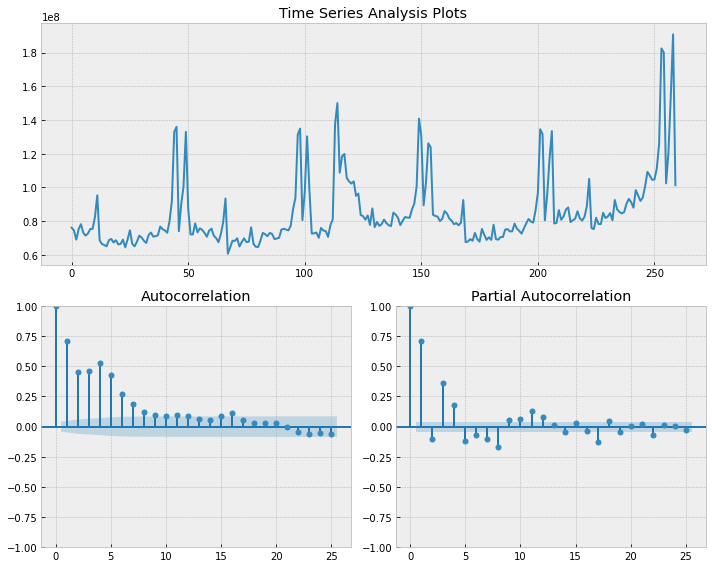

In [121]:
tsplot(df_tablespreads_US_total_sales['Total Sales'])

**From the plot of ACF, we could see the correlation coefficient does not drop to 0 quickly, but the PACF plot shows the correlation coefficient drops to 0 after 1st log, thus we will try AR(1) model.**

/Users/min/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


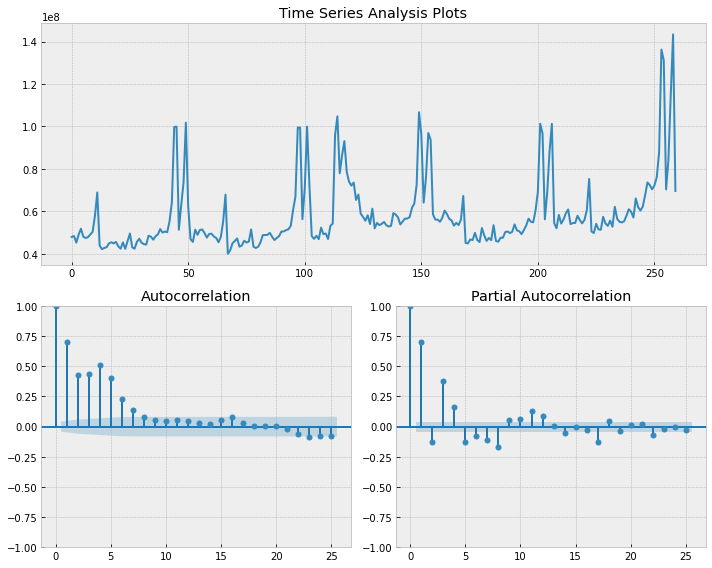

In [122]:
tsplot(df_tablespreads_US_butter_total_sales['Total Sales'])

/Users/min/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


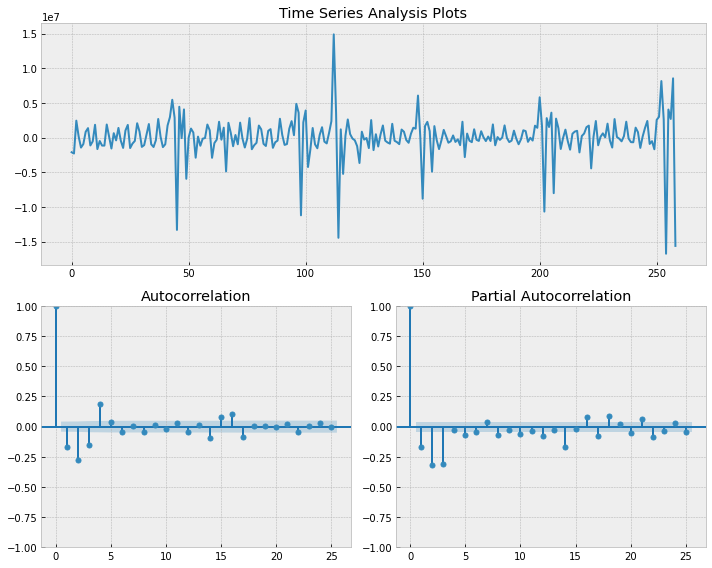

In [123]:
tsplot(df_tablespreads_US_mar_total_sales_1d)

## ARIMA Model

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Load the time series data into a pandas dataframe
df_tablespreads_US_total_sales['Date'] = pd.to_datetime(df_tablespreads_US_total_sales['Date'])
df_tablespreads_US_total_sales.set_index('Date', inplace=True)

# Fit AR(1) model
ARMA_model = ARIMA(df_tablespreads_US_total_sales['Total Sales'], order=(2, 0, 2))
results = ARMA_model.fit()

# Print the summary statistics of the model
print(results.summary())

# # Plot the original data and the fitted values from the model
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.plot(df.index, df['total_sales'], label='Original Data')
# ax.plot(df.index, results.fittedvalues, label='Fitted Values')
# ax.set_xlabel('Time')
# ax.set_ylabel('Sales')
# ax.set_title('MA(3) Model Fit')
# ax.legend()
# plt.show()


                               SARIMAX Results                                
Dep. Variable:            Total Sales   No. Observations:                  260
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -4643.388
Date:                Sat, 06 May 2023   AIC                           9298.777
Time:                        20:44:55   BIC                           9320.141
Sample:                    01-14-2018   HQIC                          9307.365
                         - 01-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.475e+07   9.85e-10    8.6e+16      0.000    8.47e+07    8.47e+07
ar.L1          0.8953      0.195      4.587      0.000       0.513       1.278
ar.L2          0.0200      0.161      0.124      0.9

/Users/min/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/min/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/Users/min/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


**For Further Reference**

***Cooking Oil***

In [121]:
df_oil_US.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95329 entries, 0 to 95328
Data columns (total 33 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Unnamed: 0                           95329 non-null  int64  
 1   Geography                            95329 non-null  object 
 2   Time                                 95329 non-null  object 
 3   Product                              95329 non-null  object 
 4   Dollar Sales No Merch                95329 non-null  float64
 5   Dollar Sales Any Merch               95329 non-null  float64
 6   Unit Sales No Merch                  95329 non-null  float64
 7   Unit Sales Any Merch                 95329 non-null  float64
 8   Volume Sales No Merch                95329 non-null  float64
 9   Volume Sales Any Merch               95329 non-null  float64
 10  Price per Unit                       95329 non-null  float64
 11  Price per Unit No Merch     

In [122]:
# Create a new column called "Price Gap' by differencing the Price per Unite No Merch and Any Merch
df_oil_US['Price Gap'] = df_oil_US['Price per Unit No Merch'] - df_oil_US['Price per Unit Any Merch']

In [123]:
# Check the Total Sales by CAG Manufacturer Value and Rank by Descending
df_oil_US_tol_sales_by_manufacturer = df_oil_US.groupby('Manufacturer').agg({'Total Sales': 'sum'}).sort_values(by = ['Total Sales'], ascending = False).reset_index()
df_oil_US_tol_sales_by_manufacturer['Rank'] = [i for i in range(1, 471)]
df_oil_US_tol_sales_by_manufacturer.set_index("Rank", inplace = True)
df_oil_US_tol_sales_by_manufacturer

,Manufacturer,Total Sales
Rank,,
1,PRIVATE LABEL,5160951002.07
2,ACH FOOD CO,1164700814.58
3,B&G FOODS INC,1103487353.90
4,RICHARDSON INTL,1020187805.45
5,VENTURA FOODS LLC,448746768.49
...,...,...
466,AMERICAN POP CORN CO,28.41
467,AXIOM ENT LLC,26.97
468,ARCHER DANIELS MIDLAND CO ADM,25.50


In [124]:
# Get the Cooking Oil Top 10 Manufacturer List based on Total Sales
df_oil_US_tol_sales_by_manufacturer_top10 = df_oil_US_tol_sales_by_manufacturer[df_oil_US_tol_sales_by_manufacturer.index <= 10]
df_oil_US_tol_sales_by_manufacturer_top10_list = list(df_oil_US_tol_sales_by_manufacturer_top10['Manufacturer'])
df_oil_US_tol_sales_by_manufacturer_top10_list

['PRIVATE LABEL',
 'ACH FOOD CO',
 'B&G FOODS INC',
 'RICHARDSON INTL',
 'VENTURA FOODS LLC',
 'THE HAIN CELESTIAL GRP INC',
 'CHOSEN FOODS INC',
 'KEHE DIST LLC',
 'FABRICA DE JABON LA CORONA',
 'POMPEIAN INC']

In [125]:
# Append CONAGRA BRANDS
df_oil_US_tol_sales_by_manufacturer_top10_list.append('CONAGRA BRANDS')
df_oil_US_tol_sales_by_manufacturer_top10_list

['PRIVATE LABEL',
 'ACH FOOD CO',
 'B&G FOODS INC',
 'RICHARDSON INTL',
 'VENTURA FOODS LLC',
 'THE HAIN CELESTIAL GRP INC',
 'CHOSEN FOODS INC',
 'KEHE DIST LLC',
 'FABRICA DE JABON LA CORONA',
 'POMPEIAN INC',
 'CONAGRA BRANDS']

In [126]:
# Keep the Top 10 and CONAGRA BRANDS Manufacturer and Set the Others as "Others"
df_oil_US['Manufacturer'] = df_oil_US['Manufacturer'].apply(lambda x: x if x in df_oil_US_tol_sales_by_manufacturer_top10_list else 'Others')

In [127]:
df_oil_US1 = df_oil_US[['Total Sales', 'Price per Unit No Merch', 'Price Gap', 'Manufacturer', 'Promotion']] 

In [128]:
# Create a list of dummies variables for the categorical variables[['CAG Manufacturer Value',  'Sub-Category Name', 'CAG Form Value', 'CAG Tier Value']]
df_oil_US2 = pd.get_dummies(df_oil_US1[['Manufacturer']])

In [129]:
df_oil_US2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95329 entries, 0 to 95328
Data columns (total 12 columns):
 #   Column                                   Non-Null Count  Dtype
---  ------                                   --------------  -----
 0   Manufacturer_ACH FOOD CO                 95329 non-null  uint8
 1   Manufacturer_B&G FOODS INC               95329 non-null  uint8
 2   Manufacturer_CHOSEN FOODS INC            95329 non-null  uint8
 3   Manufacturer_CONAGRA BRANDS              95329 non-null  uint8
 4   Manufacturer_FABRICA DE JABON LA CORONA  95329 non-null  uint8
 5   Manufacturer_KEHE DIST LLC               95329 non-null  uint8
 6   Manufacturer_Others                      95329 non-null  uint8
 7   Manufacturer_POMPEIAN INC                95329 non-null  uint8
 8   Manufacturer_PRIVATE LABEL               95329 non-null  uint8
 9   Manufacturer_RICHARDSON INTL             95329 non-null  uint8
 10  Manufacturer_THE HAIN CELESTIAL GRP INC  95329 non-null  uint8
 11  Ma

In [130]:
df_oil_US1 = df_oil_US1.drop(['Manufacturer'], axis = 1)
df_oil_US1 = pd.concat([df_oil_US1, df_oil_US2], axis = 1)

In [131]:
df_oil_US1.head()

,Total Sales,Price per Unit No Merch,Price Gap,Promotion,Manufacturer_ACH FOOD CO,Manufacturer_B&G FOODS INC,Manufacturer_CHOSEN FOODS INC,Manufacturer_CONAGRA BRANDS,Manufacturer_FABRICA DE JABON LA CORONA,Manufacturer_KEHE DIST LLC,Manufacturer_Others,Manufacturer_POMPEIAN INC,Manufacturer_PRIVATE LABEL,Manufacturer_RICHARDSON INTL,Manufacturer_THE HAIN CELESTIAL GRP INC,Manufacturer_VENTURA FOODS LLC
0,43850.84,2.16,0.59,1,1,0,0,0,0,0,0,0,0,0,0,0
1,4215668.84,6.48,1.69,1,1,0,0,0,0,0,0,0,0,0,0,0
2,113.37,5.30,0.64,1,0,0,0,0,0,0,1,0,0,0,0,0
3,11758.15,12.03,4.34,1,0,0,0,0,0,0,1,0,0,0,0,0
4,51.09,2.32,0.32,1,0,0,0,0,0,0,1,0,0,0,0,0


In [132]:
# Choose the dependent and independent variables
y2 = df_oil_US1['Total Sales']
X2 = df_oil_US1.drop('Total Sales', axis = 1)

In [133]:
# Add new constant column for the intercept
X2 = sm.add_constant(X2)

In [134]:
# Linear regression 2
linregr2 = sm.OLS(y2, X2, missing = 'drop').fit()

In [135]:
print(linregr2.summary())

                            OLS Regression Results                            
Dep. Variable:            Total Sales   R-squared:                       0.896
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                 3.058e+04
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        15:35:06   Log-Likelihood:            -6.7624e+05
No. Observations:               46313   AIC:                         1.353e+06
Df Residuals:                   46299   BIC:                         1.353e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [136]:
# VIF dataframe
X1 = X1.dropna()
vif_data1 = pd.DataFrame()
vif_data1["feature"] = X1.columns
  
# calculating VIF for each feature
vif_data1["VIF"] = [variance_inflation_factor(X1.values, i)
                          for i in range(len(X1.columns))]
  
print(vif_data1)

/Users/min/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/min/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/min/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                      feature                 VIF
0                       const                0.00
1                   Promotion                1.15
2             Total Sales_Oil                6.66
3           Total Sales_Spray                7.17
4     Price per Unit No Merch                2.99
..                        ...                 ...
127   CAG Ounces Value_8.9 OZ                 NaN
128  CAG Ounces Value_8.93 OZ                 NaN
129    CAG Ounces Value_80 OZ 3002399751580330.50
130     CAG Ounces Value_9 OZ                 NaN
131    CAG Ounces Value_90 OZ                 NaN

[132 rows x 2 columns]


**The results of VIF values showing that there is no multicollinearity existed in the explanatory variables Price Gap and Price per Unit No Merch in Linear Regression 2.**

``Based on the results shown above, we could see the coefficient of Price Gap is negatively significant with p-value 0.000, showing that 1 dollar increase in Price Gap of Cooking Oil will bring 6968 dollars decrease in Total Sales of Cooking Oil at 0.01 confidence level. ``

***Cooking Spray***

In [137]:
# Create a new column called "Price Gap' by differencing the Price per Unite No Merch and Any Merch
df_spray_US['Price Gap'] = df_spray_US['Price per Unit No Merch'] - df_spray_US['Price per Unit Any Merch']

In [138]:
# Check the Total Sales by CAG Manufacturer Value and Rank by Descending
df_spray_US_tol_sales_by_manufacturer = df_spray_US.groupby('Manufacturer').agg({'Total Sales': 'sum'}).sort_values(by = ['Total Sales'], ascending = False).reset_index()
df_spray_US_tol_sales_by_manufacturer['Rank'] = [i for i in range(1, 68)]
df_spray_US_tol_sales_by_manufacturer.set_index("Rank", inplace = True)
df_spray_US_tol_sales_by_manufacturer

,Manufacturer,Total Sales
Rank,,
1,CONAGRA BRANDS,1129135836.81
2,PRIVATE LABEL,758010760.81
3,B & G FOODS INC.,120379669.60
4,POMPEIAN INC,39237569.36
5,CHOSEN FOODS INC,33516473.75
...,...,...
63,MARDONA SPECIALTY FOODS LTD,44.07
64,SHERWIN-WILLIAMS CO,31.76
65,CORAL INTERNACIONAL SA DE CV,22.56


In [139]:
# Get the Cooking Spary Top 10 Manufacturer List based on Total Sales
df_spray_US_tol_sales_by_manufacturer_top10 = df_spray_US_tol_sales_by_manufacturer[df_spray_US_tol_sales_by_manufacturer.index <= 10]
df_spray_US_tol_sales_by_manufacturer_top10_list = list(df_spray_US_tol_sales_by_manufacturer_top10['Manufacturer'])
df_spray_US_tol_sales_by_manufacturer_top10_list

['CONAGRA BRANDS',
 'PRIVATE LABEL',
 'B & G FOODS INC.',
 'POMPEIAN INC',
 'CHOSEN FOODS INC',
 'DEOLEO',
 'WINONA FOODS',
 'VENTURA FOODS LLC',
 'THE HAIN CELESTIAL GROUP INC',
 'SPECTRUM NATURALS, INC.']

In [140]:
# Keep the Top 10 and CONAGRA BRANDS Manufacturer and Set the Others as "Others"
df_spray_US['Manufacturer'] = df_spray_US['Manufacturer'].apply(lambda x: x if x in df_spray_US_tol_sales_by_manufacturer_top10_list else 'Others')

In [141]:
df_spray_US1 = df_spray_US[['Total Sales', 'Price per Unit No Merch', 'Price Gap', 'Manufacturer', 'Promotion']] 

In [142]:
# Create a list of dummies variables for the categorical variables[['CAG Manufacturer Value',  'Sub-Category Name', 'CAG Form Value', 'CAG Tier Value']]
df_spray_US2 = pd.get_dummies(df_spray_US1[['Manufacturer']])

In [143]:
df_spray_US2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12832 entries, 0 to 12831
Data columns (total 11 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Manufacturer_B & G FOODS INC.              12832 non-null  uint8
 1   Manufacturer_CHOSEN FOODS INC              12832 non-null  uint8
 2   Manufacturer_CONAGRA BRANDS                12832 non-null  uint8
 3   Manufacturer_DEOLEO                        12832 non-null  uint8
 4   Manufacturer_Others                        12832 non-null  uint8
 5   Manufacturer_POMPEIAN INC                  12832 non-null  uint8
 6   Manufacturer_PRIVATE LABEL                 12832 non-null  uint8
 7   Manufacturer_SPECTRUM NATURALS, INC.       12832 non-null  uint8
 8   Manufacturer_THE HAIN CELESTIAL GROUP INC  12832 non-null  uint8
 9   Manufacturer_VENTURA FOODS LLC             12832 non-null  uint8
 10  Manufacturer_WINONA FOODS                  128

In [144]:
df_spray_US1 = df_spray_US1.drop(['Manufacturer'], axis = 1)
df_spray_US1 = pd.concat([df_spray_US1, df_spray_US2], axis = 1)

In [145]:
df_spray_US1.head()

,Total Sales,Price per Unit No Merch,Price Gap,Promotion,Manufacturer_B & G FOODS INC.,Manufacturer_CHOSEN FOODS INC,Manufacturer_CONAGRA BRANDS,Manufacturer_DEOLEO,Manufacturer_Others,Manufacturer_POMPEIAN INC,Manufacturer_PRIVATE LABEL,"Manufacturer_SPECTRUM NATURALS, INC.",Manufacturer_THE HAIN CELESTIAL GROUP INC,Manufacturer_VENTURA FOODS LLC,Manufacturer_WINONA FOODS
0,24701.17,3.20,0.36,1,0,0,0,0,0,0,0,0,0,0,1
1,38766.81,2.22,-0.07,1,0,0,0,0,1,0,0,0,0,0,0
2,5658.70,7.60,1.24,1,0,0,0,0,1,0,0,0,0,0,0
3,2799.13,7.48,1.23,1,0,0,0,0,1,0,0,0,0,0,0
4,86.36,3.15,NaN,0,0,0,0,0,1,0,0,0,0,0,0


In [146]:
# Choose the dependent and independent variables
y3 = df_spray_US1['Total Sales']
X3 = df_spray_US1.drop('Total Sales', axis = 1)

In [147]:
# Add new constant column for the intercept
X3 = sm.add_constant(X3)

In [148]:
# Linear regression 3
linregr3 = sm.OLS(y3, X3, missing = 'drop').fit()

In [149]:
print(linregr3.summary())

                            OLS Regression Results                            
Dep. Variable:            Total Sales   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                     1165.
Date:                Sat, 06 May 2023   Prob (F-statistic):               0.00
Time:                        15:38:05   Log-Likelihood:            -1.3442e+05
No. Observations:                9193   AIC:                         2.689e+05
Df Residuals:                    9180   BIC:                         2.690e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------

``Based on the results shown above, we could see the coefficient of Price Gap is positively significant with p-value 0.000, showing that 1 dollar increase in Price Gap of Cooking Spray will bring 7895 dollars increase in Total Sales of Cooking Spray at 0.01 confidence level. ``